# Мобильные приложения — Анализ поведения пользователей в мобильном приложении

**Мобильное приложение** - "Ненужные вещи".

**Функционал** - площадка объявлений С2С, на которой осуществляются договоренности по продаже личных ("ненужных") вещей между частными лицами через размещение объявлений.

**ЗАДАЧА ПРОЕКТА:**

На основании данных, представленных в 2-х датасетах, о событиях, совершенных в мобильном приложении начиная с 07.10.2019:

**файл mobile_sources.csv**

* userId — идентификатор пользователя

* source — источник, с которого пользователь установил приложение

**файл mobile_dataset.csv:**

* event.time — время совершения

* user.id — идентификатор пользователя

* event.name — действие пользователя

**виды действий:**

* advert_open — открыл карточки объявления

* photos_show — просмотрел фотографий в объявлении

* tips_show — увидел рекомендованные объявления

* tips_click — кликнул по рекомендованному объявлению

* contacts_show и show_contacts — посмотрел номер телефона

* contacts_call — позвонил по номеру из объявления

* map — открыл карту объявлений

* search_1 — search_7 — разные действия, связанные с поиском по сайту

* favorites_add — добавил объявление в избранное

**Проанализировать** связь целевого события - просмотр контактов - и других действий пользователей

**Произвести** проверку статистических гипотез

**Сделать выводы и рекомендации**

# Материалы:

* **презентация:** https://disk.yandex.ru/i/UTxU-fM4f38JGg
* **дашборд:**     https://public.tableau.com/app/profile/victoria8304/viz/vbout_YaPP12_dash/sheet4

## Предподготовка данных

**Задача:**

* создание рабочей среды
* загрузка данных
* проверка регистров, корректности записей и названий (преобразования в случае необходимости)
* проверка типов данных ((преобразования в случае необходимости)
* проверка пропущенных значений (преобразования в случае необходимости)
* проверка дубликатов (преобразования в случае необходимости)
* проверка минимальных и максимальных значений на аномалии (преобразования в случае необходимости)

In [1]:
# загружаем библиотеки,
# подготавливаем рабочее пространство

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math as mth

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 110)

In [2]:
# загружаем данные датасета mobile_dataset.csv,
# выводим информацию о датасете,
# выводим случайные 5 строк таблицы

data_dataset = pd.read_csv('/datasets/mobile_dataset.csv')
data_dataset.info()
display(data_dataset.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


,event.time,event.name,user.id
5395,2019-10-09 10:20:45.416954,tips_show,9982382b-f642-4cd2-ac64-b8078ae803be
70841,2019-11-02 20:00:43.780400,photos_show,0f676893-b238-4a16-b135-6c98708c51d7
37383,2019-10-22 10:05:45.875323,search_5,4f3e9680-e104-402b-958a-74207311966a
23712,2019-10-16 20:28:43.695158,photos_show,93245533-3216-47fc-9fb2-473617be2bc1
27034,2019-10-18 01:00:02.042142,tips_show,ac907037-cafd-418f-aa45-b40cc27fd3c8


In [3]:
# загружаем данные датасета mobile_soures.csv,
# выводим информацию о датасете,
# выводим случайные 5 строк таблицы

data_sources = pd.read_csv('/datasets/mobile_soures.csv')
data_sources.info()
display(data_sources.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


,userId,source
567,19ab6ef7-c118-4213-bd3b-fd15584ef68a,yandex
3914,0b91240d-64ba-4eff-a34d-c5ad2b775ea4,other
1973,577ff487-878e-4981-9d17-b3c6f1d33b68,google
612,7f364c04-f996-4ed6-89d0-ffbe627920ab,yandex
3386,fc06dbfc-7414-4253-bdfd-157f247755e2,other


In [4]:
# приводим названия колонок в обоих датасетах к единому стандарту написания

data_dataset.columns = data_dataset.columns.str.replace(".", "_", regex=True)
print(data_dataset.columns)
print()

data_sources.columns = data_sources.columns.str.replace("userId", "user_id")
print(data_sources.columns)

Index(['event_time', 'event_name', 'user_id'], dtype='object')

Index(['user_id', 'source'], dtype='object')


In [5]:
# объединяем датасеты по user_id,
# выводим случайные 5 строк таблицы

data = data_dataset.merge(data_sources, on=['user_id'], how='left')
display(data.sample(5))

,event_time,event_name,user_id,source
20789,2019-10-15 19:28:41.685955,advert_open,42d4a5fc-f62e-445b-bc0c-d3f924144a9b,yandex
66864,2019-10-31 23:37:41.321947,photos_show,f5fa601a-7c45-4cd2-8eac-2a53bb3dcc5a,other
6819,2019-10-09 20:53:17.253325,tips_show,ac28946f-2d55-4323-abf5-5dc2264ce660,yandex
24838,2019-10-17 10:21:02.560671,tips_show,64e0fd5b-b4eb-4e12-b085-9d0a086b424d,yandex
19155,2019-10-15 09:21:59.132462,tips_show,208169aa-b695-4dfb-9e57-be9c04c7f96e,yandex


In [6]:
# приводим значения колонки event_time к типу date_time,
# округляем значение времени до секунд,
# проверяем типы данных

data['event_time']=pd.to_datetime(data['event_time'], format ='%Y-%m-%d %H:%M:%S')
data['event_time'] = data['event_time'].dt.round('S')
display(data.dtypes)

event_time    datetime64[ns]
event_name            object
user_id               object
source                object
dtype: object

In [7]:
# добавляем колонку event_date

data['event_date'] = pd.DatetimeIndex(data['event_time']).date.astype('datetime64[ns]')

In [8]:
# добавляем колонку week_day

data['week_day'] = data['event_date'].dt.weekday

In [9]:
# выводим 5 случайных строк таблицы

display(data.sample(5))

,event_time,event_name,user_id,source,event_date,week_day
28870,2019-10-18 19:08:50,tips_show,22421bcf-4abf-4a84-9609-f97d49ffdf34,yandex,2019-10-18,4
38661,2019-10-22 16:43:52,search_1,9f9034e9-966d-4052-b3ab-5389f9585eb3,yandex,2019-10-22,1
31407,2019-10-19 19:55:29,tips_show,7b1cd14b-cdd0-4a37-a612-bd302052d0f5,google,2019-10-19,5
58571,2019-10-29 10:44:11,advert_open,06e08f33-c8f6-4664-8e7c-3606982cafa5,yandex,2019-10-29,1
14725,2019-10-13 18:07:53,tips_show,74ce0b05-468e-436f-931b-aee71386d643,yandex,2019-10-13,6


In [10]:
# проверяем наличие пропущенных значений

print('Количество пропущенных значений в таблице:\n', data.isnull().sum())

Количество пропущенных значений в таблице:
 event_time    0
event_name    0
user_id       0
source        0
event_date    0
week_day      0
dtype: int64


In [11]:
# проверяем наличие дубликатов в таблице

print('Количество дубликатов в таблице:', data.duplicated().sum())

Количество дубликатов в таблице: 1118


In [12]:
# выводим задублированные строки

data_dupl_lst = data.duplicated(keep=False).to_frame().rename(columns={0:'dupl'})
data_dupl = data_dupl_lst[data_dupl_lst['dupl'] == True]
display(data[data.index.isin(data_dupl.index)].sort_values(by='user_id', ascending = True))

,event_time,event_name,user_id,source,event_date,week_day
39297,2019-10-22 20:49:43,photos_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,2019-10-22,1
39296,2019-10-22 20:49:43,photos_show,00753c79-ea81-4456-acd0-a47a23ca2fb9,yandex,2019-10-22,1
37905,2019-10-22 13:02:27,map,007d031d-5018-4e02-b7ee-72a30609173f,yandex,2019-10-22,1
37906,2019-10-22 13:02:27,map,007d031d-5018-4e02-b7ee-72a30609173f,yandex,2019-10-22,1
8112,2019-10-10 14:46:37,tips_show,017c6afc-965d-4c94-84ee-f0e326998e30,other,2019-10-10,3
...,...,...,...,...,...,...
18244,2019-10-14 20:33:50,photos_show,fc546918-70e2-4a04-a9a2-bc358f1db5c9,yandex,2019-10-14,0
1931,2019-10-07 20:32:50,photos_show,ffc01466-fdb1-4460-ae94-e800f52eb136,yandex,2019-10-07,0
1932,2019-10-07 20:32:50,photos_show,ffc01466-fdb1-4460-ae94-e800f52eb136,yandex,2019-10-07,0
54109,2019-10-27 20:00:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,google,2019-10-27,6


In [13]:
# удаляем дубликаты,
# делаем повторную проверку

data = data.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов в таблице после удаления:',data.duplicated().sum())
print()
print('Количество записей в таблице после удаления дубликатов:',data.shape)

Количество дубликатов в таблице после удаления: 0

Количество записей в таблице после удаления дубликатов: (73079, 6)


In [14]:
# проверяем минимальные и максимальные значения колонки event_time

print('Минимальная дата события: {}, максимальная дата события: {}'.format(data['event_time'].min(), data['event_time'].max()))

Минимальная дата события: 2019-10-07 00:00:00, максимальная дата события: 2019-11-03 23:58:13


In [15]:
# проверяем кол-во уникальных значений в колонке event_name

print(data.groupby('event_name')['user_id'].count().sort_values(ascending=False))

event_name
tips_show        39892
photos_show       9372
advert_open       6145
contacts_show     4302
map               3760
search_1          3489
favorites_add     1414
search_5          1049
tips_click         811
search_4           701
contacts_call      538
search_3           521
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: user_id, dtype: int64


In [16]:
# выводим 5 случайных примеров записи действий contacts_show и show_contacts

display(data[data['event_name'] == 'contacts_show'].sample(5))
display(data[data['event_name'] == 'show_contacts'].sample(5))

,event_time,event_name,user_id,source,event_date,week_day
20449,2019-10-15 18:58:16,contacts_show,0eb4f4c9-d8be-4630-8ca0-bdac8bad6d18,yandex,2019-10-15,1
42556,2019-10-24 01:39:09,contacts_show,9bddc719-ea5f-4c61-9815-0c5adef5a830,yandex,2019-10-24,3
41033,2019-10-23 16:30:42,contacts_show,b654786a-354c-4fa5-8323-9619e15fd05f,other,2019-10-23,2
60746,2019-10-30 11:12:46,contacts_show,9a8f5b68-87a6-4468-93e1-2130d5de0e63,other,2019-10-30,2
4501,2019-10-08 19:44:45,contacts_show,9d2c3d71-c6e8-4957-bc3d-e3a00752519d,google,2019-10-08,1


,event_time,event_name,user_id,source,event_date,week_day
66320,2019-11-01 11:23:15,show_contacts,e38cb669-7335-4d56-9de5-c8d5d2f13fd3,google,2019-11-01,4
63842,2019-10-31 12:14:54,show_contacts,f8502cbc-9322-46eb-bc9f-8f261a94c1a2,yandex,2019-10-31,3
66783,2019-11-01 13:38:16,show_contacts,e38cb669-7335-4d56-9de5-c8d5d2f13fd3,google,2019-11-01,4
63840,2019-10-31 12:14:39,show_contacts,f8502cbc-9322-46eb-bc9f-8f261a94c1a2,yandex,2019-10-31,3
66794,2019-11-01 13:40:06,show_contacts,e38cb669-7335-4d56-9de5-c8d5d2f13fd3,google,2019-11-01,4


In [17]:
# объединяем данные по действиям contacts_show и show_contacts

data['event_name'] = data['event_name'].replace('show_contacts', 'contacts_show')
print(data.groupby('event_name')['user_id'].count().sort_values(ascending=False))

event_name
tips_show        39892
photos_show       9372
advert_open       6145
contacts_show     4381
map               3760
search_1          3489
favorites_add     1414
search_5          1049
tips_click         811
search_4           701
contacts_call      538
search_3           521
search_6           460
search_2           324
search_7           222
Name: user_id, dtype: int64


In [18]:
# выводим кол-во уникальных user_id

print('Количество уникальных клиентов:', data['user_id'].nunique())

Количество уникальных клиентов: 4293


### Выводы

* данные предоставлены в 2-х датасетах
* датасет **mobile_dataset.csv** содержит 74 197 записей и 3 колонки, тип данных *object*
* датсет **mobile_soures.csv** содержит 4 293 записи и 2 колонки, тип данных *object*
* оба датасета содержат колонки с уникальным номером пользователя
* в качестве преобразования названия колонок приведены к единому стандарту написания
* произведено объединение датасетов по ключу уникального номера пользователя
* данные колонки *event_time* приведены к типу *datetime64[ns]*
* данные колонки *event_time* округлены до значения секунд
* добавлена колонка event_date, данные приведены к типу *datetime64[ns]*
* добавлена колонка week_day
* пропущенные значения не выявлены
* проверка на дубликаты выявила 1 118 задублированных записей; дубликаты удалены
* проверка минимальной и максимальной даты событий показала, что данные предоставлены за период с 7 октября 2019 г (00:00:00) по 3 ноября 2019 г (23:58:13) или 28 полных дней
* анализ данных по целевому действию *просмотр контактов*, записанных двумя разными способами, показал, что действия ничем не отличаются по содержанию; появление небольшого числа записей (79 vs 4 302) с зеркальным написанием скорее всего связано с выгрузкой данных из разных БД; данные объединены под единой записью *contacts_show*
* датасет содержит информацию о 4 293 уникальных пользователях

## Исследовательский анализ данных (EDA)

**Задача:**

* изучить характер распределения данных по событиям на уникального пользователя методом describe() **на всем датасете**
* изучить характер распределения данных по событиям на уникального пользователя методом describe() **на выборке по целевой переменной contacts_show**
* изучить длительность сессий, конверсию сессий в целевое действие
* воспроизвести модель поведения **активных** пользователей по количеству целевых действий в приложении (*набор действий, порядок выполнения действий, периодичность, длительность сессий, источник установки приложения*), построить графики
* воспроизвестим одель поведения **базовых** пользователей в приложении (*набор действий, порядок выполнения действий, периодичность, длительность сессий, источник установки приложения*), построить графики
* воспроизвести модельповедения **нецелевых** пользователей, которые не совершили целевое действие
* изучить распределение действий по дням недели
* проверить метрику **DAU**

**!!! В связи с особенностью параметра *tips_show*, который показывается всем пользователям автоматически, т.е. осуществление этого действия не зависит от воли пользователя, параметр не будет учитываться в данном анализе**

### Общий анализ данных о действиях пользователей

In [19]:
# создаем функцию, определяющую границы верхнего уса

def upper_limit(data, column):
    quantiles = data[column].quantile([0.25, 0.5, 0.75])
    q1 = quantiles[0.25]
    q3 = quantiles[0.75]
    upper_limit = q3 + 1.5*(q3 - q1)
    return upper_limit

In [20]:
# создаем переменную, отражающую количество действий на уникального пользователя за период
# на всем датасете,
# исключаем параметр tips_show

data_all_users = data.pivot_table(index = 'user_id', columns = 'event_name', values = 'event_time', aggfunc = ('count'))\
.drop('tips_show', axis=1)
display(data_all_users.head(2))

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click
user_id,,,,,,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00157779-810c-4498-9e05-a1e9e3cedf93,2.0,5.0,11.0,2.0,NaN,33.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# выводим статистическую информацию по кол-ву действий всех пользователей

display(data_all_users.describe().T.sort_values(by='count', ascending=False))

,count,mean,std,min,25%,50%,75%,max
event_name,,,,,,,,
map,1456.0,2.582418,4.613599,1.0,1.0,1.0,3.0,71.0
photos_show,1095.0,8.558904,13.002459,1.0,3.0,5.0,9.0,175.0
contacts_show,981.0,4.465851,8.982642,1.0,1.0,2.0,4.0,137.0
search_1,787.0,4.433291,6.003312,1.0,2.0,3.0,5.0,68.0
advert_open,751.0,8.182423,12.608780,1.0,2.0,4.0,8.5,131.0
search_5,663.0,1.582202,1.806864,1.0,1.0,1.0,2.0,25.0
search_4,474.0,1.478903,1.986364,1.0,1.0,1.0,1.0,35.0
favorites_add,351.0,4.028490,6.284610,1.0,1.0,2.0,5.0,63.0
search_6,330.0,1.393939,1.206351,1.0,1.0,1.0,1.0,17.0


**Выводы по стат информации о кол-ве действий всех пользователей:**

* пользователи приложения проявляют разную активность с точки зрения набора действий в приложении
* в **ТОП3** действий входят:
>
> map - 1 456 клиент открыл карту объявлений
>
> photos_show - 1 095 клиентов просмотрели фотографии в объявлениях
>
> contacts_show - 981 клиент просмотрел контакты, т.е. совершил целевое действие
>
> search_1 - 787 клиентов осуществили поиск 1
>

* в **ФЛОП3** действий входят:
>
> contacts_call - 213 клиентов позвонили по номеру из объявления
>
> search_3 - 208 клиентов осуществили поиск 3-го типа
>
> search_7 - 157 клиентов осуществили поиск 7-го типа
>

* **средние** значения колеблятся в диапазоне от 1,34 (*search_2*) до 8,56 (*photos_show*)
* **стандартные отклонения** имеют достаточно большой разброс от 1,21 (*search_6*) до 13,00 (*photos_show*), что потребует стандартизации данных при построении модели для прогноза
* **минимальные** значения все равны 1
* **медианные** значения находятся в диапазоне от 1 до 5 (*photos_show*)
* разброс **максимальных** значений от 13 (*search_7*) до 175 (*photos_show*), т.е. самый активный клиент за период просмотрел фотографии 175 раз

In [22]:
# создаем выборку данных по пользователям,
# осуществившим целевое действие просмотра контактов (contacts_show)

data_target = data_all_users[data_all_users['contacts_show'] >0]
display(data_target.shape)

(981, 14)

In [23]:
# выводим статистическую информацию по кол-ву действий пользователей,
# осуществивших целевое действие просмотра контактов

display(data_target.describe().T.sort_values(by='count', ascending=False))

,count,mean,std,min,25%,50%,75%,max
event_name,,,,,,,,
contacts_show,981.0,4.465851,8.982642,1.0,1.0,2.0,4.00,137.0
photos_show,339.0,10.315634,18.060813,1.0,2.0,4.0,10.00,175.0
map,289.0,3.688581,6.919169,1.0,1.0,2.0,4.00,66.0
search_1,237.0,5.654008,9.072128,1.0,1.0,3.0,5.00,68.0
contacts_call,213.0,2.525822,2.370324,1.0,1.0,2.0,3.00,17.0
advert_open,138.0,11.485507,15.951677,1.0,2.0,6.0,13.00,99.0
favorites_add,136.0,3.095588,3.812025,1.0,1.0,1.0,4.00,23.0
search_5,114.0,2.184211,3.144220,1.0,1.0,1.0,2.00,25.0
tips_click,100.0,3.320000,4.004745,1.0,1.0,2.0,4.00,30.0


**Выводы по стат информации о кол-ве действий пользователей, осуществивших целевое действие:**

* целевое действие просмотра контактов осуществили 23% пользователей - 981 из 4 293
* в **ТОП3** списка действий этих пользователей входят:
>
> photos_show - 339 клиентов просмотрели фотографии в объявлениях
>
> map - 289 клиентов открыли карту объявлений 
>
> search_1 - 237 клиентов осуществили поиск 1
>

Действия  photos_show и map поменялись местами в рейтинге. По составу список ТОП3 остался неизменным.

* в **ФЛОП3** действий входят:
>
> search_6 - 52 клиента осуществили поиск 6-го типа
>
> search_3 - 38 клиентов осуществили поиск 3-го типа
>
> search_7 - 25 клиентов осуществили поиск 7-го типа
>

Последние 2 позиции сопадают с общим списком. На третью позицию с конца вышел *поиск 6-го типа* вместо *contacts_call* из общего списка.

* **средние** значения колеблятся в диапазоне от 1,24 (*search_7*) до 11,49 (*advert_open*)
* **стандартные отклонения** имеют достаточно большой разброс от 0,72 (*search_7*) до 18,06 (*photos_show*)
* **минимальные** значения все равны 1
* **медианные** значения находятся в диапазоне от 1 до 6 (*advert_open*)
* разброс **максимальных** значений от 4 до 175 (*photos_show*), можно сделать предположение, что самый активный пользователь по количеству просмотров фотографий попал в "целевую" группу

### Анализ сессий

#### Длительность сессий

* **За длительность сессии** в данном исследовании принята разница между временем осуществления первого действия и последнего действия в рамках одного календарного дня на уровне уникального пользователя.

In [24]:
# создаем таблицу длительности сессий

# создаем таблицу максимальных значений времени осуществления действия униканым пользователем в рамках одного дня
data_session_dur_max = data.groupby(['user_id', 'event_date'])['event_time'].agg('max').reset_index()

# создаем таблицу минимальных значений времени осуществления действия униканым пользователем в рамках одного дня
data_session_dur_min = data.groupby(['user_id', 'event_date'])['event_time'].agg('min').reset_index()

# объединяем таблицы на уровне уникального пользователя и дня осуществления действий
data_session_dur = data_session_dur_max.merge(data_session_dur_min, on = ['user_id', 'event_date'], how = 'left')\
.rename(columns = {'event_time_x':'event_time_max', 'event_time_y':'event_time_min'})

# создаем колонку с расчетом разницы между максимальными и минимальными значениями осуществления действий
# одним уникальным пользователейм в один день
data_session_dur['session_duration'] = (data_session_dur['event_time_max'] - data_session_dur['event_time_min']).dt.seconds

# проверяем типы данных созданной таблицы и выводим 2 случайных строки
print(data_session_dur.dtypes)
display(data_session_dur.sample(2))

user_id                     object
event_date          datetime64[ns]
event_time_max      datetime64[ns]
event_time_min      datetime64[ns]
session_duration             int64
dtype: object


,user_id,event_date,event_time_max,event_time_min,session_duration
1260,251023fc-8396-4905-b04b-82247d6832bf,2019-10-24,2019-10-24 15:59:41,2019-10-24 15:56:19,202
2627,558b56e9-fc34-438d-9d12-74cd3d864dfa,2019-10-28,2019-10-28 14:55:37,2019-10-28 14:55:37,0


In [25]:
# выводим стат данные о длительности сессий

data_session_dur['session_duration'].describe()

count     7817.000000
mean      4981.994755
std      11410.082235
min          0.000000
25%        147.000000
50%        708.000000
75%       2925.000000
max      85049.000000
Name: session_duration, dtype: float64

In [26]:
# выводим информацию о количестве сессий по длительности

display(data_session_dur['session_duration']\
        .value_counts()\
        .to_frame()\
        .reset_index()\
        .rename(columns={'index':'длительность сессии', 'session_duration':'кол-во сессий'})
        .sort_values(by='длительность сессии', ascending=False).T)

2934   1501   1873   3609   2911   1202   2564   2024  \
длительность сессии  85049  84643  84426  83173  82802  82528  81711  81697   
кол-во сессий            1      1      1      1      1      1      1      1   

                      2062   2212   2883   1378   3581   3263   3384   2624  \
длительность сессии  81445  81125  80775  80495  80398  80277  80197  79826   
кол-во сессий            1      1      1      1      1      1      1      1   

                      2210   3113   2935   3373   3410   2206   1694   2361  \
длительность сессии  79728  79727  78906  78104  78056  77675  77529  77465   
кол-во сессий            1      1      1      1      1      1      1      1   

                      2112   3339   1736   3580   1904   2984   1813   1683  \
длительность сессии  77375  77254  76450  76364  76334  75991  75910  75666   
кол-во сессий            1      1      1      1      1      1      1      1   

                      3199   2916   2008   3217   3301   2766   2021   2368  \
длительность сессии  75465  74820  74728  74693  74377  73860  73489  73448   
кол-во сессий            1      1      1      1      1      1      1      1   

                      3313   3706   2880   2943   2552   2189   1974   2825  \
длительность сессии  73064  72654  72607  72343  71846  71716  71409  70692   
кол-во сессий            1      1      1      1      1      1      1      1   

                      2814   1712   1558   3726   3550   1903   1967   1464  \
длительность сессии  69902  69817  68966  68508  68481  68138  67906  67815   
кол-во сессий            1      1      1      1      1      1      1      1   

                      2494   3385   1864   2913   1561   3038   2571   3147  \
длительность сессии  67576  67374  67291  66724  66450  66400  66369  66331   
кол-во сессий            1      1      1      1      1      1      1      1   

                      1396   1805   3355   2598   2063   1366   2667   3253  \
длительность сессии  65983  65674  65641  65299  65065  64873  63895  63865   
кол-во сессий            1      1      1      1      1      1      1      1   

                      1697   2530   2889   2879   2949   2709   1934   2194  \
длительность сессии  63257  63075  62366  62338  62130  61990  61721  61473   
кол-во сессий            1      1      1      1      1      1      1      1   

                      3274   3561   3519   3052   2584   3049   2227   3019  \
длительность сессии  60007  59920  59776  59213  59120  58709  58214  58092   
кол-во сессий            1      1      1      1      1      1      1      1   

                      1304   2386   1314   2620   1711   2376   1216   3791  \
длительность сессии  56798  56631  56500  55242  55081  54542  54405  54331   
кол-во сессий            1      1      1      1      1      1      1      1   

                      3461   2426   3682   1324   1331   2462   3467   1719  \
длительность сессии  54007  52645  52520  52515  52495  52383  52028  51930   
кол-во сессий            1      1      1      1      1      1      1      1   

                      3681   2763   1718   1568   2454   2385   2642   1498  \
длительность сессии  51347  51325  50843  50759  50548  50484  50465  50294   
кол-во сессий            1      1      1      1      1      1      1      1   

                      1638   3169   3445   1193   3436   1966   1986   3235  \
длительность сессии  49994  49959  49765  49646  49632  49471  49461  49413   
кол-во сессий            1      1      1      1      1      1      1      1   

                      3428   2582   2616   3372   3192   2286   1616   3106  \
длительность сессии  49350  49111  49087  49042  48822  48707  48606  48439   
кол-во сессий            1      1      1      1      1      1      1      1   

                      1342   1543   1739   3535   3388   2692   2471   2421  \
длительность сессии  48288  48033  47808  47694  47449  47443  47182  46490   
кол-во сессий            1      1      1      1      1  

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


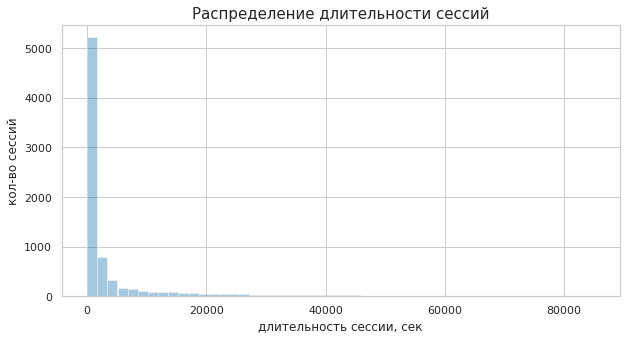

In [27]:
# строим гистограмму распределения данных о длительности сессий

plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', palette='tab10')
sns.distplot(data_session_dur['session_duration'], kde=False)
plt.title('Распределение длительности сессий', fontsize=15)
plt.ylabel('кол-во сессий', fontsize=12)
plt.xlabel('длительность сессии, сек', fontsize=12)
plt.show()

In [28]:
# выводим стат информацию
# о минимальных значениях длительности сессий

display(data_session_dur[data_session_dur['session_duration'] == 0]\
        .groupby('event_date')['session_duration']\
        .count()\
        .describe())

count    28.000000
mean     36.178571
std      10.797989
min      13.000000
25%      27.750000
50%      38.500000
75%      44.250000
max      54.000000
Name: session_duration, dtype: float64

In [29]:
# определяем границы верхнего уса распределения данных о длительности сессий

session_duration_upper_limit = upper_limit(data_session_dur, 'session_duration')
print("Верхняя граница session_duration:", session_duration_upper_limit)

Верхняя граница session_duration: 7092.0


In [30]:
# выводим стат информацию
# о максимальных значениях длительности сессий

display(data_session_dur[data_session_dur['session_duration'] > 7092]\
        .groupby('event_date')['session_duration']\
        .count()\
        .describe())

count    28.000000
mean     45.964286
std      12.102899
min      19.000000
25%      39.500000
50%      46.500000
75%      53.500000
max      67.000000
Name: session_duration, dtype: float64

In [31]:
# выводим информацию о максимально длительной сессии

display(data_session_dur[data_session_dur['session_duration'] == 85049])
display(data[data['user_id'] == '12681fdf-d1d1-454b-9b92-e8a3ccfaf07b'])

,user_id,event_date,event_time_max,event_time_min,session_duration
660,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,2019-11-03,2019-11-03 23:47:36,2019-11-03 00:10:07,85049


,event_time,event_name,user_id,source,event_date,week_day
69630,2019-11-02 18:54:27,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,yandex,2019-11-02,5
69659,2019-11-02 19:13:42,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,yandex,2019-11-02,5
70248,2019-11-03 00:10:07,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,yandex,2019-11-03,6
71668,2019-11-03 16:54:45,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,yandex,2019-11-03,6
73063,2019-11-03 23:47:36,photos_show,12681fdf-d1d1-454b-9b92-e8a3ccfaf07b,yandex,2019-11-03,6


**Выводы по графику и данным:**

* в течении изучаемого периода времени пользователи осуществили **7 817** сессий
* **средняя** длительность сессии составила 4 982 секунды, или 83 минуты
* **минимальная** длительность зафиксирована равной 0; распределение нулевых сессий по дням достаточно равномерное и не имеет аномалий; очевидно нулевые сессии возникли в связи с округлением данных до секунд
* **50%** пользователей уложились в 708 секунд, или 12 минут
* значения, превышающие границу верхнего уса (выбросы) также достаточно равномерно распроеделены по дням без аномальных всплесков
* **максимальная** длительность сессии составила 85 049 секунд, или сутки; клиент начал сессию ночью и очевидно забыл выйти из приложения; за сутки было осуществлено 3 действия по просмотру фотографий

#### Конверсия сессий

In [32]:
# аггрегируем данные на уровне сессий,
# пропущенные значения заменяем на 0,
# создаем колонку session_id

data_session_conv = data\
.pivot_table(index=['event_date', 'user_id'], columns = 'event_name', values = 'event_time', aggfunc=('count'))\
.reset_index()\
.drop('event_date', axis=1)\
.drop('user_id', axis=1)\
.fillna(0)

# придаем данным бинарный характер,
# заменяем кол-во действий по типу в рамках одной сессии
# на признак совершений действия = 1

data_session_conv[data_session_conv > 0] = 1
data_session_conv = data_session_conv.reset_index().rename(columns=({'index':'session_id'}))

display(data_session_conv.sample(5))
print(data_session_conv.columns)

event_name,session_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
1504,1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2204,2204,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2640,2640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3293,3293,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1634,1634,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['session_id', 'advert_open', 'contacts_call', 'contacts_show',
       'favorites_add', 'map', 'photos_show', 'search_1', 'search_2',
       'search_3', 'search_4', 'search_5', 'search_6', 'search_7',
       'tips_click', 'tips_show'],
      dtype='object', name='event_name')


In [33]:
# создаем матрицу действий по сессиям,
# объединяем таблицу data_session_conv с собой

data_session_conv2 = data_session_conv.merge(data_session_conv, how='inner', on='session_id')

# создаем сводную таблицу по целевому действию,
# преобразуем данные

x_lst = ['advert_open_x', 'contacts_call_x'\
         , 'favorites_add_x', 'map_x', 'photos_show_x', 'search_1_x', 'search_2_x'\
         , 'search_3_x', 'search_4_x', 'search_5_x', 'search_6_x', 'search_7_x'\
         , 'tips_click_x', 'tips_show_x', 'contacts_show_x']

y_lst = ['advert_open_y', 'contacts_call_y'\
         , 'favorites_add_y', 'map_y', 'photos_show_y', 'search_1_y', 'search_2_y'\
         , 'search_3_y', 'search_4_y', 'search_5_y', 'search_6_y', 'search_7_y'\
         , 'tips_click_y', 'tips_show_y', 'contacts_show_y']

data_session_conv3 = data_session_conv2.pivot_table(index = x_lst, columns=y_lst, values='session_id', aggfunc=('count'))\
.reset_index()\
.drop(x_lst, axis=1)\
.rename(columns={0.0:'нет', 1.0:'да'})\
.fillna(0)\
.T.reset_index()

# добавляем колонку с кол-вом уникальных сессий
data_session_conv3['session_total'] = data_session_conv3.sum(axis=0)

# удаляем перекрестные колонки
data_session_conv3 = data_session_conv3.drop(data_session_conv3.columns[15:360], axis=1)

/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [34]:
# создаем таблицу уникальных типов сессий с конверсией
# делаем выборку всех типов сессий, конвертировавшихся в целевое действие,
# делаем выборку всех типов сессий, не конвертировавшихся в целевое действие,
# объединяем таблицы, делаем преобразования

y_lst1 = ['advert_open_y', 'contacts_call_y'\
         , 'favorites_add_y', 'map_y', 'photos_show_y', 'search_1_y', 'search_2_y'\
         , 'search_3_y', 'search_4_y', 'search_5_y', 'search_6_y', 'search_7_y'\
         , 'tips_click_y', 'tips_show_y']

data_session_conv_yes = data_session_conv3[data_session_conv3['contacts_show_y'] == 'да']
data_session_conv_no = data_session_conv3[data_session_conv3['contacts_show_y'] == 'нет']
data_session_conv4 = data_session_conv_yes.merge(data_session_conv_no, on=y_lst1, how='left')

# получаем уникальный номер каждого типа сессии
data_session_conv4 = data_session_conv4.reset_index().fillna(0)

# удаляем колонку contacts_show_y_y

data_session_conv4 = data_session_conv4.drop(['contacts_show_y_y'], axis=1)


# переименовываем колонки

data_session_conv4.columns = data_session_conv4.columns.str.replace("_y", "")
data_session_conv4 = data_session_conv4.rename(columns=({'index':'session_type_id', 'session_total_x':'conversion_yes'\
                                    , 'session_total':'conversion_no'}))

# добавляем колонки с общим кол-вом сессий и конверсией

data_session_conv4['session_total'] = data_session_conv4['conversion_yes'] + data_session_conv4['conversion_no']
data_session_conv4['session_conversion'] = (data_session_conv4['conversion_yes'] / data_session_conv4['session_total']).round(2)

# удаляем колонку contacts_show_x

data_session_conv4 = data_session_conv4.drop(['contacts_show_x'], axis=1)

display(data_session_conv4.sort_values(by='session_total', ascending=False).head(10))

,session_type_id,advert_open,contacts_call,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show,conversion_yes,conversion_no,session_total,session_conversion
1,1,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,286.0,1685.0,1971.0,0.15
27,27,нет,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,107.0,861.0,968.0,0.11
33,33,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,173.0,655.0,828.0,0.21
30,30,нет,нет,нет,нет,да,да,нет,нет,нет,нет,нет,нет,нет,нет,76.0,562.0,638.0,0.12
26,26,нет,нет,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,39.0,390.0,429.0,0.09
85,85,да,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,29.0,267.0,296.0,0.10
3,3,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,да,44.0,141.0,185.0,0.24
76,76,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,10.0,121.0,131.0,0.08
0,0,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,116.0,0.0,116.0,1.00
75,75,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,5.0,92.0,97.0,0.05


In [35]:
# выводим стат данные по типам сессий

display(data_session_conv4.describe().T)

,count,mean,std,min,25%,50%,75%,max
session_type_id,128.0,63.500000,37.094474,0.00,31.75,63.50,95.25,127.0
conversion_yes,128.0,11.281250,34.020591,1.00,1.00,1.00,5.25,286.0
conversion_no,128.0,47.289062,185.261176,0.00,0.00,3.00,18.00,1685.0
session_total,128.0,58.570312,215.692282,1.00,2.00,6.00,29.25,1971.0
session_conversion,128.0,0.480625,0.369809,0.04,0.15,0.33,1.00,1.0


In [36]:
# создаем рейтинг ТОП10 типов сессий по кол-ву

session_top_10 = data_session_conv4['session_total'].sort_values(ascending=False)\
.head(10).reset_index().rename(columns=({'index':'session_type_id'}))

session_top_10_conv = data_session_conv4[data_session_conv4['session_type_id'].isin(session_top_10['session_type_id'])]
display(session_top_10_conv.sort_values(by='session_total', ascending=False))

,session_type_id,advert_open,contacts_call,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show,conversion_yes,conversion_no,session_total,session_conversion
1,1,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,286.0,1685.0,1971.0,0.15
27,27,нет,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,107.0,861.0,968.0,0.11
33,33,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,173.0,655.0,828.0,0.21
30,30,нет,нет,нет,нет,да,да,нет,нет,нет,нет,нет,нет,нет,нет,76.0,562.0,638.0,0.12
26,26,нет,нет,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,39.0,390.0,429.0,0.09
85,85,да,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,29.0,267.0,296.0,0.10
3,3,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,да,44.0,141.0,185.0,0.24
76,76,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,10.0,121.0,131.0,0.08
0,0,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,116.0,0.0,116.0,1.00
75,75,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,5.0,92.0,97.0,0.05


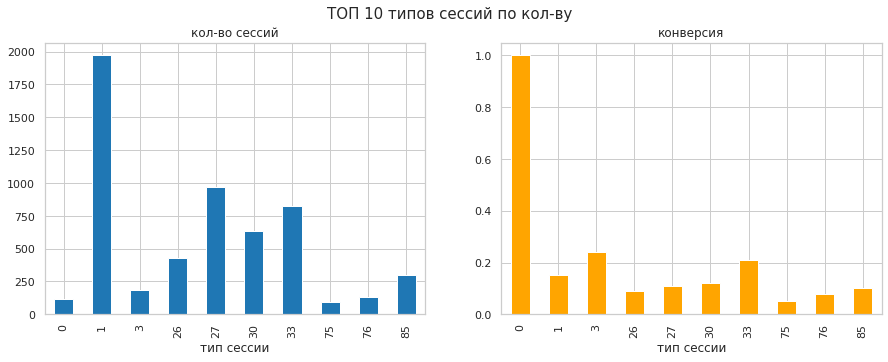

In [37]:
# строим графики рейтинга ТОП10:
# кол-во сессий, уровень конверсии

fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.suptitle('ТОП 10 типов сессий по кол-ву', fontsize=15)

session_top_10_conv['session_total'].plot(ax=axs[0], kind='bar', title='кол-во сессий', xlabel='тип сессии')
session_top_10_conv['session_conversion'].plot(ax=axs[1], kind='bar', title='конверсия', color='orange', xlabel='тип сессии')


plt.show()

**Выводы по графикам и данным:**

* по набору уникальных действий выявлено **128 типов** сессий
* **самый популярный** тип собрал **1 971** сессию
* **максимальное** значение **неконверсионных** сессий в рамках 1 типа = **1 685**
* **максимальное** значение **конверсионных** сессий в рамках 1 типа = **286**
* **ТОП 10** по количеству набранных сессий составили типы:
>
> **1** **tips_show** = 286 сессий с конверсией / 1 685 сессий без конверсии / **конверсия = 15%**
>
> **27** **photos_show** = 107 сессий с конверсией / 861 сессия без конверсии / **конверсия = 4%**
>
> **33** **map + tips_show** = 173 сессии с конверсией / 655 сессий без конверсии / **конверсия = 21%**
>
> **30** **photos_show + search_1** = 76 сессий с конверсией / 562 сессий без конверсии / **конверсия = 12%**
>
> **26** **search_1** = 39 сессий с конверсией / 390 сессий без конверсии / **конверсия = 9%**
>
> **85** **advert_open + map + tips_show** = 29 сессий с конверсией / 267 сессий без конверсии / **конверсия = 10%**
>
> **3** **tips_click + tips_show** = 44 сессии с конверсией / 141 сессия без конверсии / **конверсия = 24%**
>
> **76** **advert_open + tips_click** = 10 сессий с конверсией / 121 сессия без конверсии / **конверсия = 8%**
>
> **0** **contacts_show** = 116 сессий с конверсией / 0 сессий без конверсии / **конверсия = 100%**
>
> **75** **advert_open** = 5 сессий с конверсией / 95 сессий без конверсии / **конверсия = 5%**
>

### Анализ действий самого активного пользователя

In [38]:
# изучаем распределение данных о целевом действии по уникальным пользователям
# выводим информацию о том, какое кол-во пользователей осуществило какое кол-во просмотров

display(data_target['contacts_show']\
        .value_counts()\
        .to_frame()\
        .reset_index()\
        .rename(columns={'index':'кол-во просмотров', 'contacts_show':'кол-во пользователей'})
        .sort_values(by='кол-во просмотров', ascending=False).T)

,29,34,28,30,24,23,39,27,38,35,40,36,25,26,37,32,21,31,12,33,17,19,20,22,16,18,14,13,15,9,10,11,8,7,6,5,4,3,2,1,0
кол-во просмотров,137.0,86.0,83.0,75.0,68.0,65.0,63.0,62.0,61.0,59.0,47.0,42.0,39.0,36.0,32.0,29.0,28.0,26.0,25.0,23.0,22.0,21.0,19.0,18.0,17.0,16.0,15.0,14.0,13.0,12.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
кол-во пользователей,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,3.0,2.0,2.0,2.0,4.0,3.0,4.0,4.0,4.0,13.0,13.0,7.0,18.0,19.0,33.0,38.0,47.0,71.0,105.0,185.0,380.0


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


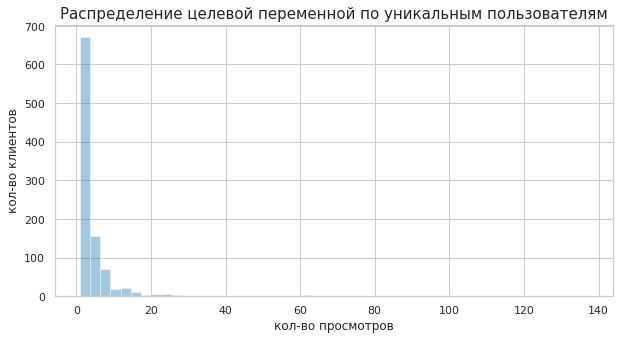

In [39]:
# изучаем распределение данных о целевом действии по уникальным пользователям
# строим гистограмму распределения данных

plt.figure(figsize=(10, 5))
sns.distplot(data_target['contacts_show'], kde=False)
plt.title('Распределение целевой переменной по уникальным пользователям', fontsize=15)
plt.xlabel('кол-во просмотров', fontsize=12)
plt.ylabel('кол-во клиентов', fontsize=12)
plt.show()

**Выводы по графику и данным:**

* распределение данных имеет ассиметричный характер, скошено вправо
* 75% клиентов осуществили целевое действие от 1 до 4 раз
* имеются выбросы, максимальное кол-во целевых действий, осуществленных 1 клиентом - 137 раз

In [40]:
# определяем границы верхнего уса распределения данных целевой переменной

contacts_show_upper_limit = upper_limit(data_target,'contacts_show')
print("Верхняя граница contacts_show:", contacts_show_upper_limit)

Верхняя граница contacts_show: 8.5


In [41]:
# определяем user_id самого активного пользователя по целевой переменной

data_max = data_target[data_target['contacts_show'] == 137]
display(data_max)

# создаем выборку по самому активному пользователю
# без учета действий tops_show

data_max_all_events = data[(data['user_id'] == 'e38cb669-7335-4d56-9de5-c8d5d2f13fd3')\
                           & (data['event_name'] != 'tips_show')]

# выводим количество совершенных действий самым активным пользователем

display(data_max_all_events.groupby('event_name').agg({'event_time':'count'}))
       

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click
user_id,,,,,,,,,,,,,,
e38cb669-7335-4d56-9de5-c8d5d2f13fd3,1.0,NaN,137.0,1.0,13.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,7.0


,event_time
event_name,
advert_open,1
contacts_show,137
favorites_add,1
map,13
search_5,1
search_6,1
tips_click,7


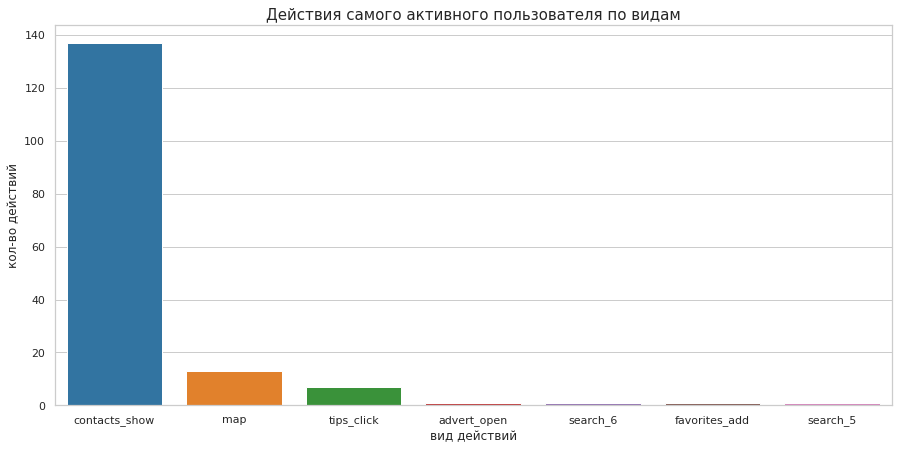

In [42]:
# строим график кол-ва действий самого активного пользователя по видам

plt.figure(figsize=(15, 7))

sns.countplot(data = data_max_all_events, x = 'event_name', order=data_max_all_events["event_name"].value_counts().index)
plt.title('Действия самого активного пользователя по видам', fontsize = 15)
plt.xlabel('вид действий', fontsize = 12)
plt.ylabel('кол-во действий', fontsize = 12)

plt.show()

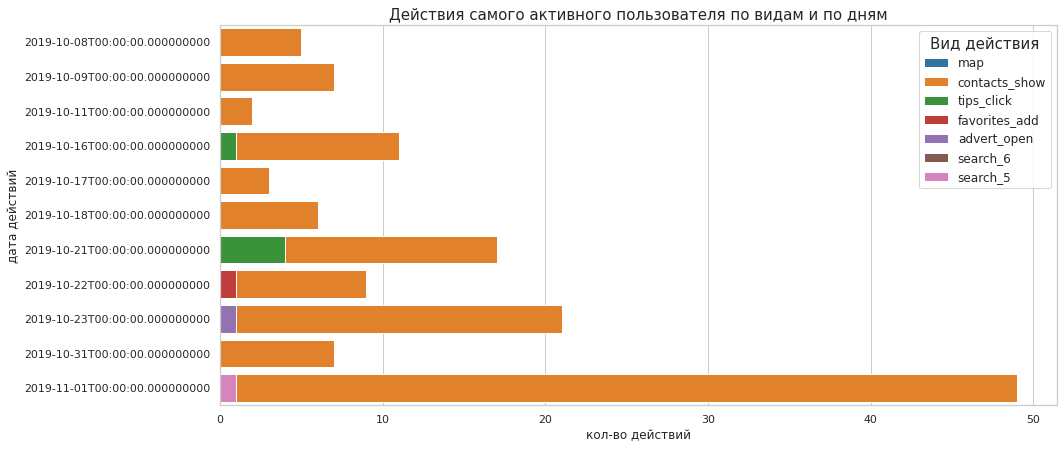

In [43]:
# строим график кол-ва действий самого активного пользователя по видам и по дням

plt.figure(figsize=(15, 7))
sns.countplot(data = data_max_all_events, y = 'event_date', hue = 'event_name', dodge=False)
plt.title('Действия самого активного пользователя по видам и по дням', fontsize = 15)
plt.xlabel('кол-во действий', fontsize = 12)
plt.ylabel('дата действий', fontsize = 12)
plt.legend(fontsize = 12, \
               loc= 'upper right', \
               title="Вид действия", \
               title_fontsize = 15)
plt.show()

**Выводы по графикам и данным:**

* самый активный пользователь с точки зрения количества совершенных целевых действий пользовался приложением **13 дней из 28**: с 8 по 11 октября, 14 октября, 16-18 октября, 21-23 октября, 31 октября - 1 ноября
* всего пользователь осуществил за этот период **356** действий, ТОП3 из которых:
>
> 137 - contacts_show
>
> 13 - map
>
> 7 - tips_click

* в период с **8 октября по 1 ноября** в его действиях преобладали contacts_show
* **16 и 21 октября** осуществлялись действия tips_click
* **22 октября** пользователь добавлял объявления в избранное
* **23 октября** открывал рекламу
* **1 ноября** осуществил поиск 5

In [44]:
# проверяем длительность сессий самого активного пользователя

display(data_session_dur[data_session_dur['user_id'] == 'e38cb669-7335-4d56-9de5-c8d5d2f13fd3'].describe())

,session_duration
count,13.000000
mean,8925.769231
std,5926.536484
min,648.000000
25%,6743.000000
50%,8086.000000
75%,11878.000000
max,22087.000000


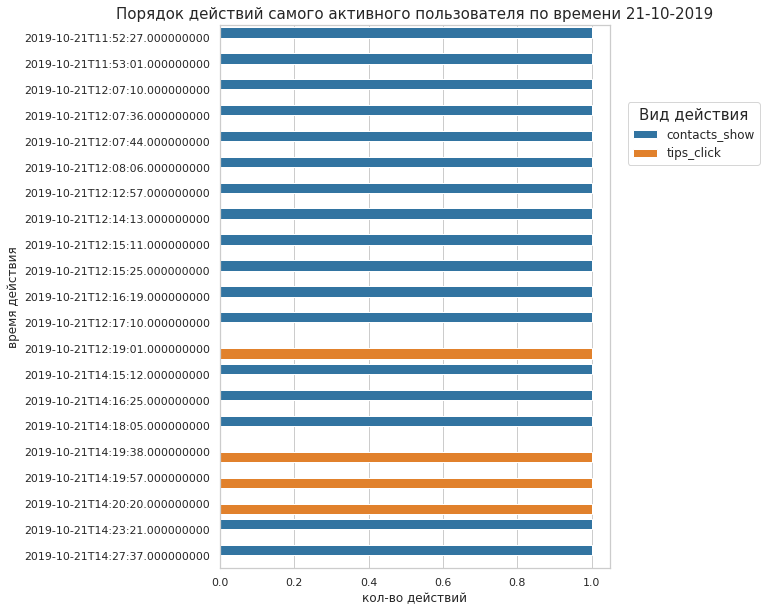

In [45]:
# строим график распределения действий самого активного целевого пользователя во времени
# на примере 1 дня 21.10.2019 (2 типа действий кроме tips_show)

plt.figure(figsize=(7, 10))
sns.countplot(data = data_max_all_events[data_max_all_events['event_date'] == '2019-10-21']\
              , y = 'event_time', hue = 'event_name')
plt.legend()
plt.title('Порядок действий самого активного пользователя по времени 21-10-2019', fontsize = 15)
plt.xlabel('кол-во действий', fontsize = 12)
plt.ylabel('время действия', fontsize = 12)
plt.legend(fontsize = 12, \
               bbox_to_anchor= (1.03, 0.8), \
               title="Вид действия", \
               title_fontsize = 15)
plt.show()

**Выводы по графику и данным:**

* за исследуемый период самый активный пользователь осуществил 13 сессий от 648 секунд (11 минут) до 22 087 секунд (6 часов), что находится в пределах нормы данного датасета
* порядок действий имеет логичный характер, действия contacts_show и tips_click чередуют друг друга

### Анализ действий группы активных пользователей

In [46]:
# создаем выборку данных по активным пользователям,
# у которых кол-во целевых действий попало в диапазон выше границы верхнего уса,
# но ниже максимального значения

data_target_top = data_all_users[(data_all_users['contacts_show'] > 8.5) & (data_all_users['contacts_show'] < 137)]
display(data_target_top.sample(2))
display(data_target_top['contacts_show'].describe())

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click
user_id,,,,,,,,,,,,,,
9d2c3d71-c6e8-4957-bc3d-e3a00752519d,3.0,NaN,11.0,NaN,11.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,4.0
db839af4-756e-4536-a5a7-bd0e6e21846f,NaN,NaN,9.0,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


count    102.000000
mean      20.088235
std       17.272483
min        9.000000
25%       11.000000
50%       12.500000
75%       21.750000
max       86.000000
Name: contacts_show, dtype: float64

In [47]:
# изучаем распределение данных о целевом действии в группе активных пользователей
# выводим информацию о том, какое кол-во пользователей осуществило какое кол-во просмотров

display(data_target_top['contacts_show']\
        .value_counts()\
        .to_frame()\
        .reset_index()\
        .rename(columns={'index':'кол-во просмотров', 'contacts_show':'кол-во пользоавателей'})
        .sort_values(by='кол-во просмотров', ascending=False).T)

,25,22,21,16,29,17,28,23,24,15,18,30,26,19,27,13,20,7,31,9,14,11,12,5,10,8,6,4,2,1,3,0
кол-во просмотров,86.0,83.0,75.0,68.0,65.0,63.0,62.0,61.0,59.0,47.0,42.0,39.0,36.0,32.0,29.0,28.0,26.0,25.0,23.0,22.0,21.0,19.0,18.0,17.0,16.0,15.0,14.0,13.0,12.0,11.0,10.0,9.0
кол-во пользоавателей,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,3.0,2.0,2.0,2.0,4.0,3.0,4.0,4.0,4.0,13.0,13.0,7.0,18.0


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


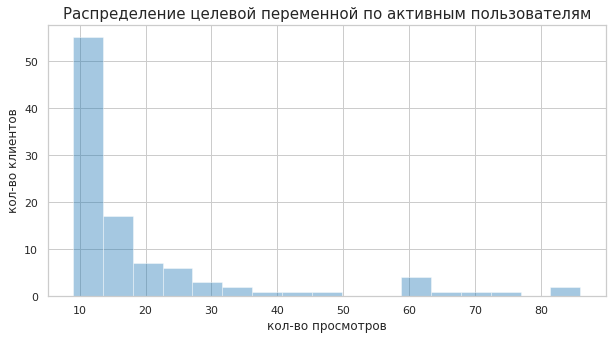

In [48]:
# строим гистограмму распределения данных

plt.figure(figsize=(10, 5))
sns.distplot(data_target_top['contacts_show'], kde=False)
plt.title('Распределение целевой переменной по активным пользователям', fontsize=15)
plt.xlabel('кол-во просмотров', fontsize=12)
plt.ylabel('кол-во клиентов', fontsize=12)
plt.show()

**Выводы по графику и данным:**

* в группу активных пользователей, количество целевых действий которых находится в диапазоне между 8 (граница верхнего уса) и 137 (максимальное значение) вошло 102 пользователя
* данные имеют ассиметричное распределение, скошенное вправо
* **минимальное** кол-во целевых действий в группе равно 9
* **среднее** значение равно 20
* **75%** пользователей в группе совершили до 22 целевых действий
* **максимальное** значение равно 86

In [49]:
# выводим количество действий, совершенных в активной группе по видам
# исключаем действие tips_show

data_active_all_events = data[(data['user_id'].isin(data_target_top.index)) & (data['event_name'] != 'tips_show')]
print('Всего действий в группе активных пользователей:', data_active_all_events['event_name'].count())
display(data_active_all_events.groupby(['event_name'])['event_time']\
        .count()\
        .sort_values(ascending=False))

Всего действий в группе активных пользователей: 3666


event_name
contacts_show    2049
map               383
photos_show       325
search_1          245
advert_open       232
contacts_call     155
tips_click         86
search_5           66
favorites_add      38
search_3           29
search_4           28
search_6           13
search_2            9
search_7            8
Name: event_time, dtype: int64

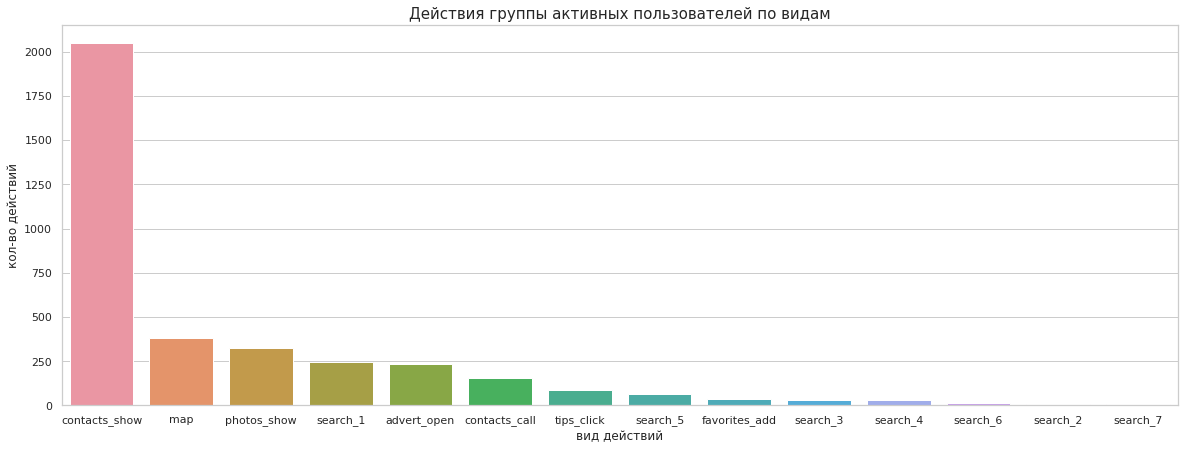

In [50]:
# строим график кол-ва действий группы активных пользователей по видам
# исключая tips_show

plt.figure(figsize=(20, 7))
sns.countplot(data = data_active_all_events, x = 'event_name', order=data_active_all_events["event_name"].value_counts().index)
plt.title('Действия группы активных пользователей по видам', fontsize = 15)
plt.xlabel('вид действий', fontsize = 12)
plt.ylabel('кол-во действий', fontsize = 12)

plt.show()

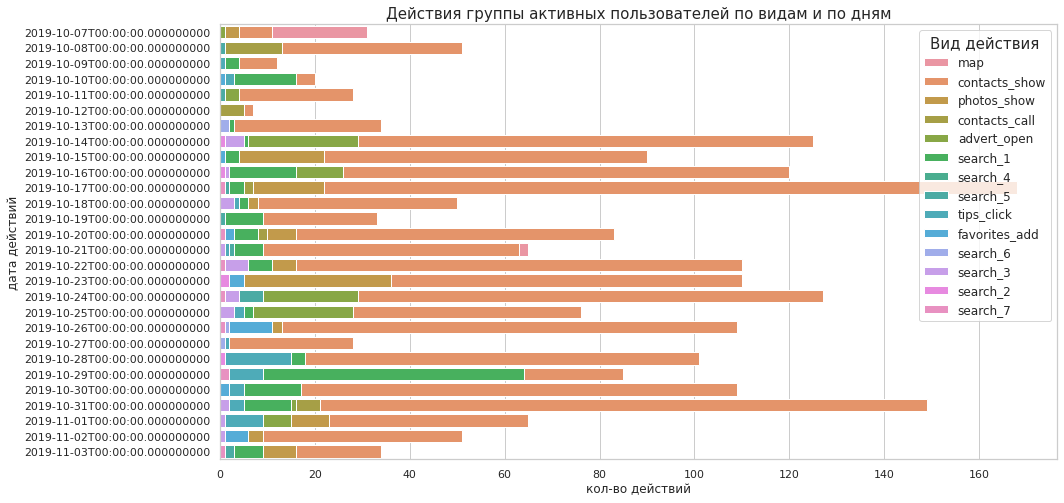

In [51]:
# строим график кол-ва действий группы активных пользователей по видам и по дням

plt.figure(figsize=(15, 8))
sns.countplot(data = data_active_all_events, y = 'event_date', hue = 'event_name', dodge=False)
plt.title('Действия группы активных пользователей по видам и по дням', fontsize = 15)
plt.xlabel('кол-во действий', fontsize = 12)
plt.ylabel('дата действий', fontsize = 12)
plt.legend(fontsize = 12, \
               loc= 'upper right', \
               title="Вид действия", \
               title_fontsize = 15)
plt.show()

**Выводы по графикам и данным:**

* группа активных пользователей совершала целевые действия в приложении на протяжении всего исследуемого периода
* всего пользователи группы осуществили за этот период **8 079** действий, ТОП3 из которых, не считая tips_show:
>
> 2 049 - contacts_show
>
> 383 - map
>
> 325 - photos_show
>

* набор действий включает в себя весь список
* среди поисковых запросов выделяется *search_1*, который входит в пятерку лидеров
* замыкает пятерку лидеров действие advert_open
* распределение действий по дням не равномерное, но лидерство в большинстве случаев принадлежит действию contacts_show; несколько раз на первое место выходит search_1

In [52]:
# проверяем длительность сессий в группе активных пользователей

display(data_session_dur[data_session_dur['user_id'].isin(data_target_top.index)].describe())

,session_duration
count,442.000000
mean,10187.918552
std,12746.957185
min,0.000000
25%,588.000000
50%,3869.500000
75%,16031.750000
max,65641.000000


In [53]:
# выводим информацию о пользователе из активной группы
# с медианным значением кол-ва целевых действий

data_active_four = data_target_top[data_target_top['contacts_show'] == 13]
display(data_active_four)

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click
user_id,,,,,,,,,,,,,,
0f951b10-782b-42e2-a421-6461d2fdfb36,2.0,NaN,13.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4e6eb20c-6a84-45b5-9cc2-f4ace35c5c31,NaN,8.0,13.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5394784c-cc24-4156-b4ad-3b2cbbb665f4,NaN,4.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d677d107-27d0-43ea-96ab-bbdbe4559b6d,NaN,2.0,13.0,NaN,NaN,1.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


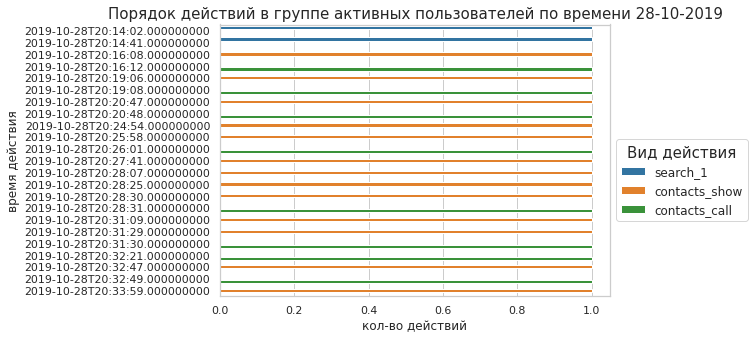

In [54]:
# строим график распределения действий группы активных пользователей во времени
# на примере 1 дня 29.10.2019 пользователя с медианным значением в группе

plt.figure(figsize=(7, 5))
sns.countplot(data = data_active_all_events[(data_active_all_events['event_date'] == '2019-10-28')\
                                            & (data_active_all_events['user_id'].isin(data_active_four.index))]\
              , y = 'event_time', hue = 'event_name')
plt.legend()
plt.title('Порядок действий в группе активных пользователей по времени 28-10-2019', fontsize = 15)
plt.xlabel('кол-во действий', fontsize = 12)
plt.ylabel('время действия', fontsize = 12)
plt.legend(fontsize = 12, \
               bbox_to_anchor= (1.0, 0.6), \
               title="Вид действия", \
               title_fontsize = 15)
plt.show()

**Выводы по графику и данным:**

* за исследуемый период группа активных пользователей осуществила 442 сессии от 0 секунд (11 минут) до 65 641 секунд (18 часов), что находится в пределах нормы данного датасета
* порядок действий имеет логичный характер, действия contacts_show и search_1 и contacts_call чередуют друг друга

### Анализ действий группы базовых пользоватлей

In [55]:
# создаем выборку данных по пользователям, составляющим базовую группу,
# у которых кол-во целевых действий попало в диапазон ниже границы верхнего уса

data_target_base = data_all_users[data_all_users['contacts_show'] < 8.5]
display(data_target_base.sample(2))
display(data_target_base['contacts_show'].describe())

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click
user_id,,,,,,,,,,,,,,
c051ea9a-65ac-4105-9f3e-86c864345f7d,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
d535be1c-0175-4d73-826a-621d4f771ba7,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


count    878.000000
mean       2.500000
std        1.876914
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: contacts_show, dtype: float64

In [56]:
# изучаем распределение данных о целевом действии в группе базовых пользователей
# выводим информацию о том, какое кол-во пользователей осуществило какое кол-во просмотров

display(data_target_base['contacts_show']\
        .value_counts()\
        .to_frame()\
        .reset_index()\
        .rename(columns={'index':'кол-во просмотров', 'contacts_show':'кол-во пользоавателей'})
        .sort_values(by='кол-во просмотров', ascending=False).T)

,7,6,5,4,3,2,1,0
кол-во просмотров,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
кол-во пользоавателей,19.0,33.0,38.0,47.0,71.0,105.0,185.0,380.0


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


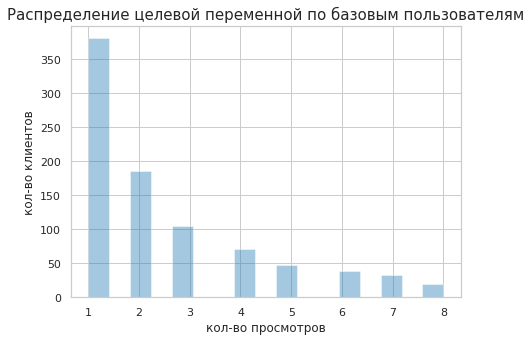

In [57]:
# строим гистограмму распределения данных

plt.figure(figsize=(7, 5))
sns.distplot(data_target_base['contacts_show'], kde=False)
plt.title('Распределение целевой переменной по базовым пользователям', fontsize=15)
plt.xlabel('кол-во просмотров', fontsize=12)
plt.ylabel('кол-во клиентов', fontsize=12)
plt.show()

**Выводы по графику и данным:**

* в группу базовых пользователей, количество целевых действий которых находится в диапазоне от 8 и ниже (граница верхнего уса) вошло 878 пользователей
* данные имеют ассиметричное распределение, скошенное вправо; не имеют выбросов
* **минимальное** кол-во целевых действий в группе равно 1
* **среднее** значение равно 2,5
* **75%** пользователей в группе совершили до 3 целевых действий
* **максимальное** значение равно 8

In [58]:
# выводим количество действий, совершенных в базовой группе по видам
# исключаем действие tips_show

data_base_all_events = data[(data['user_id'].isin(data_target_base.index)) & (data['event_name'] != 'tips_show')]
print('Всего действий в группе базовых пользователей:', data_base_all_events['event_name'].count())
display(data_base_all_events.groupby(['event_name'])['event_time']\
        .count()\
        .sort_values(ascending=False))

Всего действий в группе базовых пользователей: 10075


event_name
photos_show      3172
contacts_show    2195
advert_open      1352
search_1         1095
map               670
contacts_call     383
favorites_add     382
tips_click        239
search_5          182
search_4          121
search_3          114
search_2           87
search_6           60
search_7           23
Name: event_time, dtype: int64

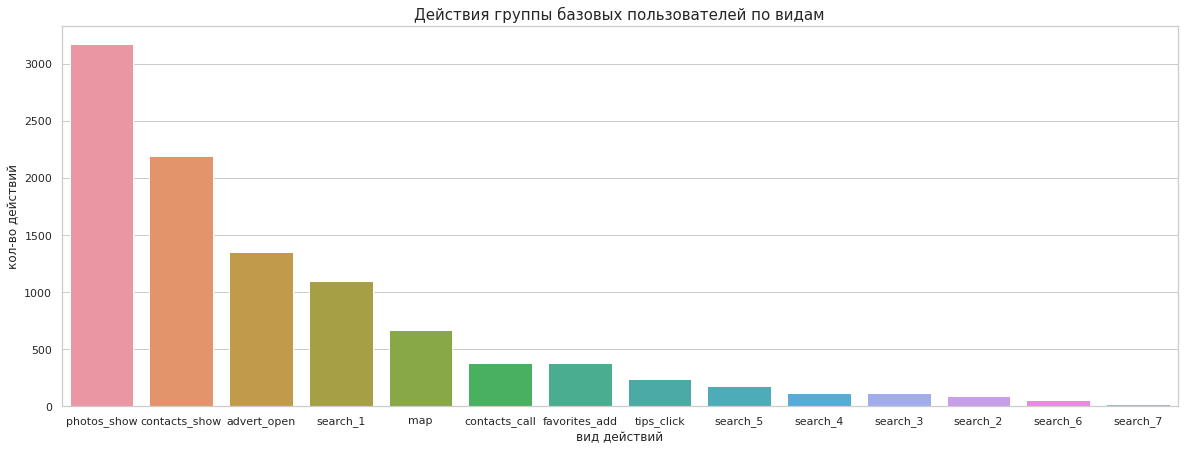

In [59]:
# строим график кол-ва действий группы базовых пользователей по видам

plt.figure(figsize=(20, 7))
sns.countplot(data = data_base_all_events, x = 'event_name', order=data_base_all_events["event_name"].value_counts().index)
plt.title('Действия группы базовых пользователей по видам', fontsize = 15)
plt.xlabel('вид действий', fontsize = 12)
plt.ylabel('кол-во действий', fontsize = 12)

plt.show()

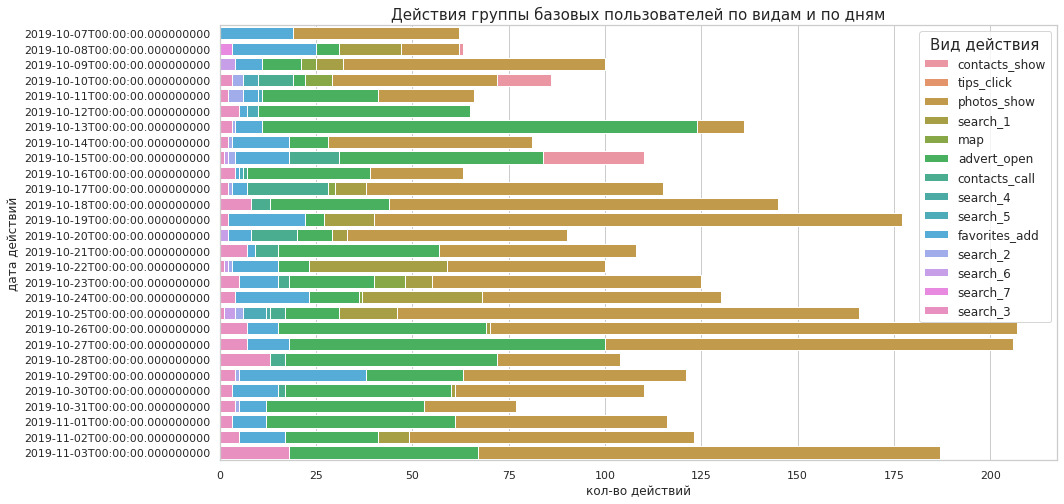

In [60]:
# строим график кол-ва действий группы базовых пользователей по видам и по дням

plt.figure(figsize=(15, 8))
sns.countplot(data = data_base_all_events, y = 'event_date', hue = 'event_name', dodge=False)
plt.title('Действия группы базовых пользователей по видам и по дням', fontsize = 15)
plt.xlabel('кол-во действий', fontsize = 12)
plt.ylabel('дата действий', fontsize = 12)
plt.legend(fontsize = 12, \
               loc= 'upper right', \
               title="Вид действия", \
               title_fontsize = 15)
plt.show()

In [61]:
# проверяем длительность сессий в группе базовых пользователей

display(data_session_dur[data_session_dur['user_id'].isin(data_target_base.index)].describe())

,session_duration
count,2020.000000
mean,6829.802475
std,13859.393095
min,0.000000
25%,134.750000
50%,893.500000
75%,5704.750000
max,83173.000000


**Выводы по графикам и данным:**

* группа базовых пользователей совершала целевые действия в приложении на протяжении всего исследуемого периода
* всего пользователи группы осуществили за этот период **18 165** действий, ТОП3 из которых кроме tips_show:
>
> 3 172 - photos_show
>
> 2 195 - contacts_show
>
> 1 352 - advert_open

* набор действий включает в себя весь список
* в пятерку лидеров тажке вошли *search_1* (1 095 действий) и *map* (670 действий)
* распределение действий по дням не равномерное, но лидерство в большинстве случаев принадлежит действию photos_show; на втором месте чаще всего идет advert_open или contacts_show / favorites_add
* всего за период группа осуществила 2 020 сессий в диапазоне от 0 до 83 173 секунд (23 часа)
* в связи со значимым стандартным отклонением целесообразно за среднее значение длительности сессии принять медиану = 14,89 минут

### Анализ действий пользователей, не совершивших целевое действие

In [62]:
# создаем выборку данных по пользователям,
# не осуществившим целевое действие просмотра контактов (contacts_show)

# производим замену пропущенных значений на 0 в переменной со всеми действиями пользователей
data_all_users_target_null = data_all_users.fillna(0)
data_all_users_null = data_all_users_target_null[data_all_users_target_null['contacts_show'] == 0]

# создаем выборку по пользователям, не осуществившим целевое действие
data_target_null = data_all_users[data_all_users.index.isin(data_all_users_null.index)]

# создаем переменную с количеством действий, совершенных в нецелевой группе по видам 
data_null_all_events = data[data['user_id'].isin(data_target_null.index)]

# выводим данные
print('Всего пользователей в нецелевой группе:', data_target_null.shape)
print()
print('Всего действий, совершенных в нецелевой группе:', data_null_all_events['event_name'].count())
display(data_target_null.describe().T.sort_values(by='count', ascending=False))

Всего пользователей в нецелевой группе: (3312, 14)

Всего действий, совершенных в нецелевой группе: 46479


,count,mean,std,min,25%,50%,75%,max
event_name,,,,,,,,
map,1167.0,2.308483,3.789141,1.0,1.0,1.0,2.0,71.0
photos_show,756.0,7.771164,9.845657,1.0,3.0,5.0,9.0,123.0
advert_open,613.0,7.438825,11.612687,1.0,2.0,4.0,8.0,131.0
search_1,550.0,3.907273,3.911189,1.0,2.0,3.0,5.0,43.0
search_5,549.0,1.457195,1.346965,1.0,1.0,1.0,1.0,22.0
search_4,386.0,1.430052,2.118938,1.0,1.0,1.0,1.0,35.0
search_6,278.0,1.388489,1.268962,1.0,1.0,1.0,1.0,17.0
tips_click,222.0,2.157658,2.218273,1.0,1.0,1.0,2.0,18.0
favorites_add,215.0,4.618605,7.384223,1.0,1.0,2.0,5.0,63.0


In [63]:
# выводим количество действий, совершенных в нецелевой группе по видам
# исключаем действие tips_show

data_null_all_events = data[(data['user_id'].isin(data_target_null.index)) & (data['event_name'] != 'tips_show')]
print('Всего действий в группе нецелевых пользователей:', data_null_all_events['event_name'].count())
display(data_null_all_events.groupby(['event_name'])['event_time']\
        .count()\
        .sort_values(ascending=False))

Всего действий в группе нецелевых пользователей: 19285


event_name
photos_show      5875
advert_open      4560
map              2694
search_1         2149
favorites_add     993
search_5          800
search_4          552
tips_click        479
search_6          386
search_3          378
search_2          228
search_7          191
Name: event_time, dtype: int64

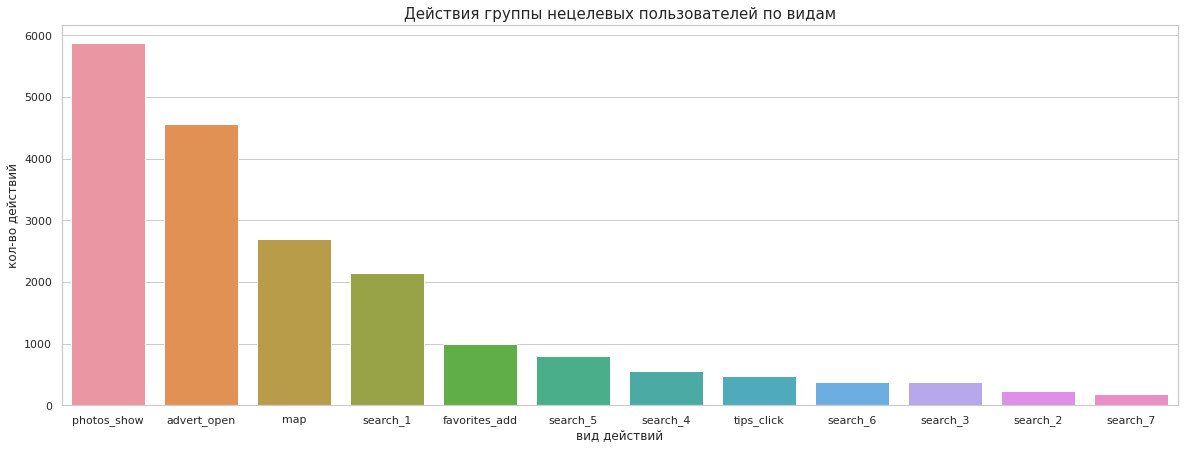

In [64]:
# строим график кол-ва действий группы нецелевых пользователей по видам

plt.figure(figsize=(20, 7))
sns.countplot(data = data_null_all_events, x = 'event_name', order=data_null_all_events["event_name"].value_counts().index)
plt.title('Действия группы нецелевых пользователей по видам', fontsize = 15)
plt.xlabel('вид действий', fontsize = 12)
plt.ylabel('кол-во действий', fontsize = 12)

plt.show()

**Выводы по графику и данным:**

* **3 312** пользователей, или 77%, не совершили целевого действия *contacts_show*, а также действия *contacts_call* в пределах изучаемого периода
* всего пользователи группы осуществили за этот период **46 479** действий, ТОП3 из которых кроме tips_show:
>
> 5 875 - photos_show (756 пользователей)
>
> 4 560 - advert_open (613 пользователей)
>
> 2694 - map (1 167 пользователей)
>

* в пятерку лидеров тажке вошли *search_1* (2 149 действий) и *favorites_add* (993 действия) 
* **средние значения** по кол-ву действий колеблятся в диапазоне от 1,22 (*search_2*) до 7,77 (*photos_show*)
* **стандартные отклонения** в группе ТОП5 по количеству колеблятся в диапазоне от 3,8 (*search_1*) до 11,61 (*advert_open*); по остальным действиям - в диапазоне 0,5 (*search_2*) и 7,4 (*favorites_add*)
* **минимальные** значения все равны 1
* **медианные** значения находятся в диапазоне от 1 до 5 (*photos_show*)
* разброс **максимальных** значений от 4 (*search_2*) до 131 (*advert_open*)

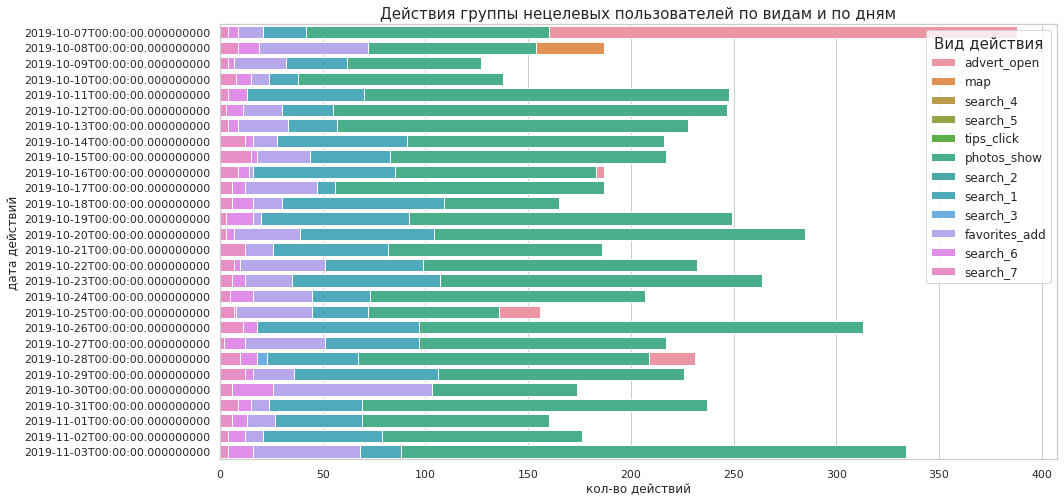

In [65]:
# строим график кол-ва действий группы нецелевых пользователей по видам и по дням

plt.figure(figsize=(15, 8))
sns.countplot(data = data_null_all_events, y = 'event_date', hue = 'event_name', dodge=False)
plt.title('Действия группы нецелевых пользователей по видам и по дням', fontsize = 15)
plt.xlabel('кол-во действий', fontsize = 12)
plt.ylabel('дата действий', fontsize = 12)
plt.legend(fontsize = 12, \
               loc= 'upper right', \
               title="Вид действия", \
               title_fontsize = 15)
plt.show()

In [66]:
# проверяем длительность сессий в группе нецелевых пользователей

display(data_session_dur[data_session_dur['user_id'].isin(data_target_null.index)].describe())

,session_duration
count,5342.000000
mean,3842.934669
std,9977.161540
min,0.000000
25%,141.000000
50%,619.500000
75%,2026.000000
max,85049.000000


**Выводы по графику:**

* распределение действий по дням группы пользователей, не совершивших целевое действие, носит неравномерный характер
* абсолютным лидером за весь период на ежедневной основе является действие *photos_show*
* на втором месте за весь период идет действие *search_1*
* иногда его опережает *favorites_add*
* группа осуществила 5 342 сессии в диапазоне от 0 до 85 049 секунд (23,5 часа)
* в связи с существенным стандартным отклонением за среднее значение длительности сессии принимаем медиану - 10,32 минуты

### Анализ действий целевой группы по дням недели

In [67]:
# аггрегируем данные о совершенных событиях
# пользователями целевой группы по дням недели

data_target_all_events = data[data['user_id'].isin(data_target.index)]
display(data_target_all_events.pivot_table(index='event_name', columns='week_day', values='event_time'\
                                           , aggfunc=('count'), margins=True)\
                                           .sort_values(by=3, ascending=False))

week_day,0,1,2,3,4,5,6,All
event_name,,,,,,,,
All,3733,4020,3808,4247,4015,3283,3494,26600
tips_show,1820,1940,1851,2148,2030,1453,1456,12698
contacts_show,624,675,685,803,648,436,510,4381
photos_show,384,415,466,451,550,580,651,3497
search_1,148,269,202,183,157,204,177,1340
advert_open,207,224,205,175,230,213,331,1585
map,245,162,148,161,139,106,105,1066
contacts_call,73,86,74,118,53,65,69,538
favorites_add,60,99,53,49,34,78,48,421


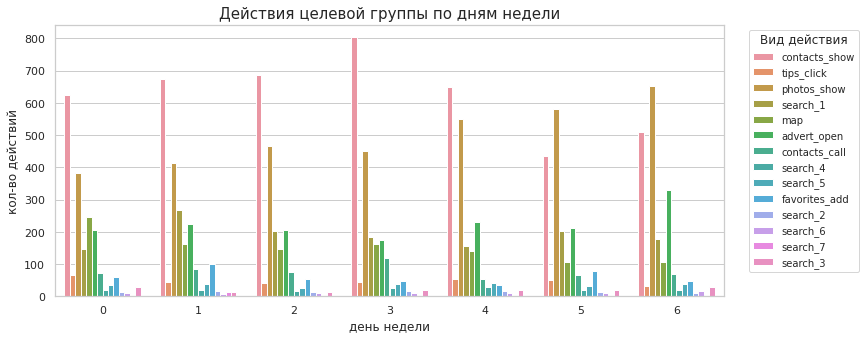

In [68]:
# строим график кол-ва действий целевой группы по дням недели,
# исключаем действие tips_show

data_target_all_events = data[(data['user_id'].isin(data_target.index)) & (data['event_name'] != 'tips_show')]
plt.figure(figsize=(12, 5))
sns.countplot(data = data_target_all_events, x = 'week_day', hue = 'event_name', dodge=True)
plt.title('Действия целевой группы по дням недели', fontsize = 15)
plt.xlabel('день недели', fontsize = 12)
plt.ylabel('кол-во действий', fontsize = 12)
plt.legend(fontsize = 10, \
               bbox_to_anchor= (1.03, 1.0), \
               title="Вид действия", \
               title_fontsize = 12)

plt.show()

**Выводы по графику и данным:**

* самым **активным** днем недели среди пользователей, осуществивших целевое действие, является **четверг**; по четвергам пользователи целевой группы совершили **4 247** действий, из них **ТОП3**, кроме tips_show:
>
> *contacts_show* = 803
>
> *photos_show* = 451
>
> *search_1* = 183
>
> *advert_open* = 175

* самым **пассивным** днем недели является **суббота**; по субботам пользователи совершили 3 283 действия, из них ТОП3, кроме tips_show:
>
> *photos_show* = 580
>
> *contacts_show* = 436
>
> *search_1* = 204
>
> *advert_open* = 213
>
* на протяжении всех дней недели тройка лидеров остается неизменной
* только в выходные дни (суббота, воскресенье) *contacts_show* и *photos_show* меняются местами
* *search_1* и *advert_open* периодически меняются местами
* распределение данных спокойное, без аномальных всплесков, с единым паттерном

### Метрика DAU

#### Все пользователи

In [69]:
# создаем переменную распределения всех пользователей по дням

dau_all = data.groupby('event_date')['user_id'].nunique()

In [70]:
# выводим стат данные распределения всех пользователей по дням

display(dau_all.describe())

count     28.000000
mean     279.178571
std       46.737291
min      178.000000
25%      238.250000
50%      292.500000
75%      310.500000
max      352.000000
Name: user_id, dtype: float64

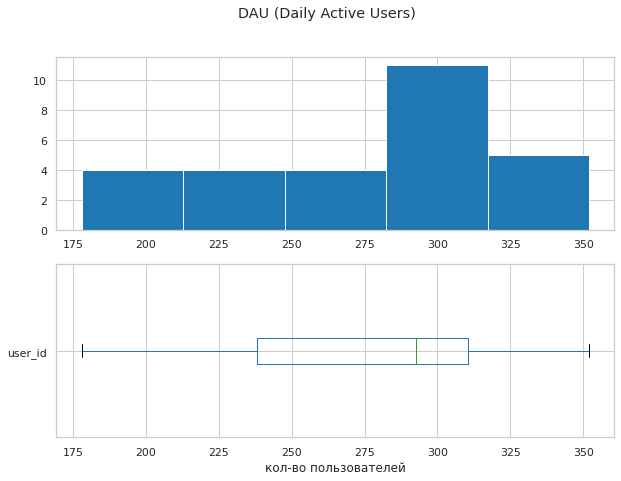

In [71]:
# строим гистограмму и диаграмму размаха
fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(10)
fig.suptitle('DAU (Daily Active Users)')
dau_all.hist(bins=5, ax=axs[0])
dau_all.plot(kind='box',vert=False,ax=axs[1],sym='b+')
plt.xlabel('кол-во пользователей')
plt.show()

**Выводы по графикам и данным:**

* распределение пользователей по дням имеет достаточно ровный одномодальный характер, без выбросов
* **минимальное** количество пользователей в день составило **279** человек 
* **среднее** количество пользователей - **178** человек
* **максимальное** - **352** человека
* значения медианы и среднего близки
* **стандартное отклонение** не велико = 46,74

#### Целевые пользователи

In [72]:
# создаем переменную распределения целевых пользователей по дням

dau_target = data_target_all_events.groupby('event_date')['user_id'].nunique()

In [73]:
# выводим стат данные распределения целевых пользователей по дням

display(dau_target.describe())

count     28.000000
mean      79.750000
std       18.800364
min       47.000000
25%       68.500000
50%       82.500000
75%       95.250000
max      106.000000
Name: user_id, dtype: float64

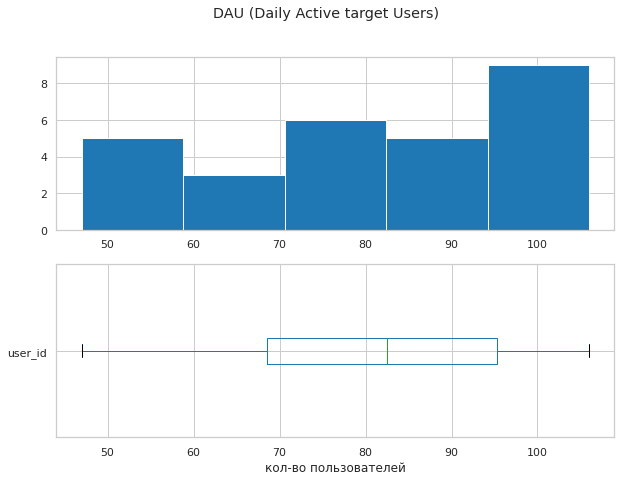

In [74]:
# строим гистограмму и диаграмму размаха
fig, axs = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(10)
fig.suptitle('DAU (Daily Active target Users)')
dau_target.hist(bins=5, ax=axs[0])
dau_target.plot(kind='box',vert=False,ax=axs[1],sym='b+')
plt.xlabel('кол-во пользователей')
plt.show()

**Выводы по графикам и данным:**

* распределение целевых пользователей по дням имеет достаточно ровный двумодальный характер, без выбросов
* **минимальное** количество целевых пользователей в день составило **51** человек 
* **среднее** количество пользователей - **88,4** человек
* **максимальное** - **119** человека
* значения медианы и среднего близки
* **стандартное отклонение** не велико = 21

### Анализ источников

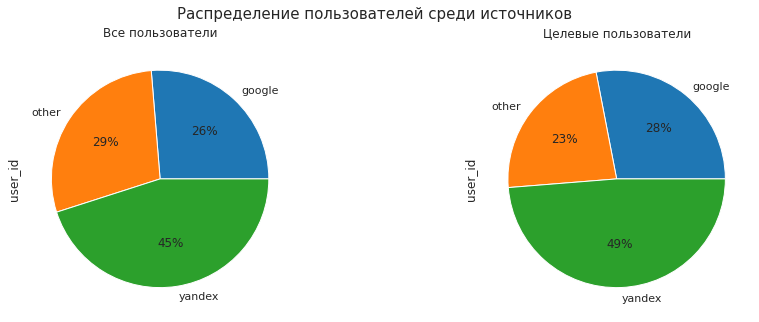

In [75]:
# строим диаграммы распределения весх пользователей и целевых пользователей по источникам

fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.suptitle('Распределение пользователей среди источников', fontsize=15)

data.groupby('source')['user_id'].nunique().plot(ax=axs[0], kind='pie', autopct='%1.0f%%', title='Все пользователи')
data_target_all_events.groupby('source')['user_id'].nunique()\
.plot(ax=axs[1], kind='pie', autopct='%1.0f%%' , title='Целевые пользователи')

plt.show()

**Выводы по графикам:**

* Яндекс является явным лидером среди источников загрузки приложения
* Среди целевых пользователей Яндекс занимает долю 49%, гугл - 28%, другие источники - 23%

### Выводы

* За изучаемый период 07.10.2019 - 03.11.2019 приложением воспользовалось 4 293 уникальных пользователя.
* Пользователи осуществили 73 097 действий.
* Всего было произведено 7 817 сессий со средней длительностью (значение медианы) 12 минут.
* По набору действий сформировано 128 типов сессий, которые осуществляли пользователи.
* ТОП3 типов сессий по количеству:
>
> **1** **tips_show** = 286 сессий с конверсией / 1 685 сессий без конверсии / **конверсия = 15%**
>
> **27** **photos_show** = 107 сессий с конверсией / 861 сессия без конверсии / **конверсия = 4%**
>
> **33** **map + tips_show** = 173 сессии с конверсией / 655 сессий без конверсии / **конверсия = 21%**
>
* В отношении целевого действия *contacts_show* всех пользователей можно разделить на 3 группы:
>
> **не целевые** пользователи - пользователи, которые не осуществили целевого действия - составляют большинство - **77%** от общего количества (**3 312 пользователей - 46 479 действий**)
>
> **целевые активные** пользователи - пользователи, которые совершили целевое действие более 8 раз за изучаемый период - составляют меньшинство - **2,5% (103 пользователя - 8 453 действия)**
>
> **целевые базовые** пользователи - пользователи, которые совершили целевое действие менее 8 раз за изучаемый период - составляют **20,5% (878 пользователей - 18 165 действий)**
>
* **модель поведения целевого активного пользователя** - 4,5 раза заходит в приложение на протяжении 28 дней, длительность сессии составляет порядка 1 часа, совершает порядка 79 действий, из них: 20 целевых действий просмотра контактов, 43 раза просматривает рекомендованные объявления, 4 раза просматривает карту и 3 раза просматривает фотографии.

**ТОП 5** действий в группе **активных пользователей**:
1. tips_show
2. **cotacts-show**
3. map
4. photos_show
5. search_1

* **модель поведения целевого базового пользователя** - 2 раза заходит в приложение на протяжении 28 дней, длительность сессии составляет порядка 15 минут, совершает всего порядка 15 действий, из них: 2,5 целевых действия просмотра контактов, 9 раз просматривает рекомендованные объявления, 3,5 раза просматривает фотографии и 1,5 раза открывает рекламу. Каждый второй загрузил приложение из Яндекса.

**ТОП 5** действий в группе **базовых пользователей**:
1. tips_show
2. photos_show
3. **cotacts-show**
4. advert_open
5. search_1

* **модель поведения нецелевого пользователя** - 1,6 раза заходит в приложение на протяжении 28 дней, длительность сессии составляет порядка 10 минут, совершает всего порядка 14 действий, из них: 8 раз просматривает рекомендованные объявления, 1,8 раза просматривает фотографии и 1,4 раза открывает рекламу, 0,8 раз просматривает карту и 0,7 раз запускает поиск 1. Каждый второй загрузил приложение из Яндекса.

**ТОП 5** действий в группе **нецелевых пользователей**:
1. tips_show
2. photos_show
3. advert_open
4. map
5. search_1

* активные пользователи по набору топовых действий очевидно имеют более четкое представление об искомом предмете и большую мотивацию на его преобретение
* модели поведения базовых и нецелевых пользователей достаточно близки; в обеих группах пользователи кроме просмотра карт и фотографий, также обращаются к рекламным объявлениям и первому поиску
* самым активным днем недели по совершению целевого действия является четверг
* пользователи достаточно равномерно распределяются по дням

## Анализ влияния событий на совершение целевого события

**Задачи:**

* изучить силу взяимосвязей между данными / действиями
* выявить корреляцию между действиями, построить тепловую карту
* построить модель прогнозирования совершения целевого действия
* сделать предположение какие действия являются ключевыми на основе оценок модели

In [76]:
# заменяем пропущенные значения на 0,
# исключаем информацию о действиях tips_show
# преобразуем данные колонки contacts_show таблицы data_all_users
# в бинарный признак 0_1

data_all_users_progn = data_all_users
data_all_users_progn.fillna(0, inplace = True)
data_all_users_progn.loc[(data_all_users_progn.contacts_show > 0), 'contacts_show'] = 1
display(data_all_users_progn['contacts_show'].value_counts())

0.0    3312
1.0     981
Name: contacts_show, dtype: int64

### Матрица корреляций

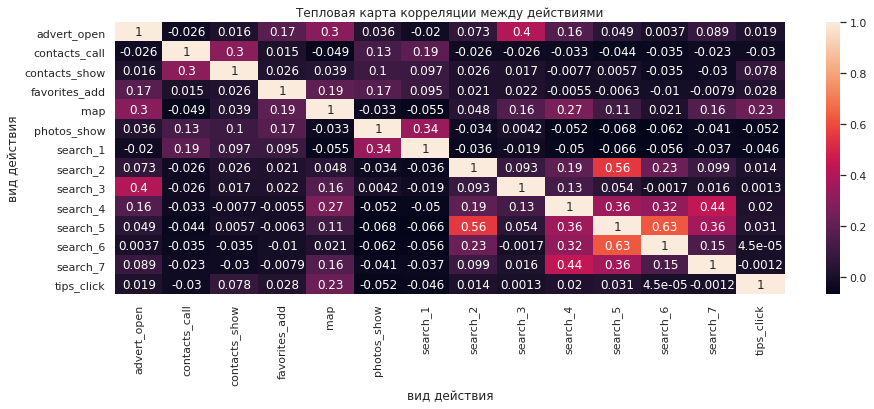

In [77]:
# строим матрицу корреляций и тепловую карту
# используем данные без учета действия tips_show

cm = data_all_users_progn.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(data = cm, annot = True)
plt.title('Тепловая карта корреляции между действиями')
plt.xlabel('вид действия')
plt.ylabel('вид действия')
plt.show()


**Выводы по графику:**

* Корреляционный анализ с помощью матрицы корреляций не выявил сильного взаимодействия между параметрами (видами действий). 
* Максимальное значение коэффициента корреляции равно 0,63

### Построение модели прогнозирования совершения целевого действия

* **задача** - выявление системы взаимосвязей между признаками и целевой перменной с применением бинарной классификации
* **целевая перменная** - contacts_show
* **размерность матрицы признаков** - 13 признаков
* **кол-во наблюдений** - 4 293
* **мультиколлинеарность** не выявлена
* **временная труктура** не важна для обучения
* **модели** - логистическая регрессия, случайный лес
* **метрики** - Accuracy, Precision, Recall

#### Формирование валидационного множества и стандартизация

In [78]:
# делим данные на признаки (матрица X) и целевую переменную (y)

X = data_all_users_progn.drop('contacts_show', axis=1)
y = data_all_users_progn['contacts_show']

# разделяем модель на обучающую и валидационную выборку

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [79]:
# стандартизируем данные
# обучаем StandartScaler на обучающей выборке

scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающий и валидационные наборы данных

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

**Выводы:**

* Так как целевая переменная не имеет временной привязки валидационное множество сформировано случайным образом в пропорции 20% х 80%.
* Данные обучающей и валидационной выборок стандартизированы.

#### Обучение модели на обучающей выборке и прогноз

**Логистическая регрессия**

In [80]:
# задаем алгоритм для модели логистической регрессии

lr_model = LogisticRegression(random_state=0, solver='liblinear')

# обучаем модель
lr_model.fit(X_train_st, y_train)

# делаем прогноз
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# выводим метрики
print("Предсказанное моделью кол-во целевых действий:", lr_predictions.sum())

Предсказанное моделью кол-во целевых действий: 42.0


**Случайный лес**

In [81]:
# задаем алгоритм для модели на основе алгоритма случайного леса

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0 )

# обучаем модель случайного леса
rf_model.fit(X_train_st, y_train)

# делаем прогноз
rf_predictions = rf_model.predict(X_test_st)

# выводим метрики
print("Предсказанное моделью кол-во целевых действий:", rf_predictions.sum())

Предсказанное моделью кол-во целевых действий: 80.0


In [82]:
# выводим значения весов признаков, присвоенные моделью

importances = rf_model.feature_importances_
feature_list = list(X_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
display(feature_results)

,feature,importance
0,contacts_call,0.353420
1,photos_show,0.137864
2,search_1,0.087328
3,advert_open,0.085889
4,map,0.082409
5,favorites_add,0.057972
6,tips_click,0.055428
7,search_5,0.035498
8,search_4,0.027702
9,search_3,0.023942


**Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке**

In [83]:
# выводим метрики для полученного прогноза по модели логистической регрессии

print('Метрики при автоматическом прогнозе по модели логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

Метрики при автоматическом прогнозе по модели логистической регрессии
Accuracy: 0.80
Precision: 0.93
Recall: 0.19


In [84]:
# выводим метрики для полученного прогноза по модели случайного леса

print('Метрики при автоматическом прогнозе по модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики при автоматическом прогнозе по модели случайного леса
Accuracy: 0.78
Precision: 0.65
Recall: 0.25


Сравнение метрик обученных моделей показывает, что:

* **ACCURACY** - логистическая регрессия показала большую долю правильных ответов, чем случайный лес - 80% vs 78%. Логистическая регрессия предсказала 42 целевых действий, случайный лес - 80. Очевидно, что случайный лес ведет себя более позитивно по отношению к результату и слабее оценивает взаимосвязь между признаками.

$$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$$



* **PRECISION** - доля правильно предсказанных положительных объектов среди всех объектов, предсказанных положительным классом, у логистической регрессии оказалась выше, чем у случайного леса: 93% vs 65%. Метрика показывает, что у логистической регрессии кол-во ошибочно положительных оценок существенно меньше.

$$Precision = \frac{TP}{TP+FP}$$

* **RECALL** - метрика показала самые низкие результаты. Доля правильно найденных положительных объектов среди всех объектов положительного класса у логистической регрессии оказалась ниже, чем у случайного леса: 19% vs 25%. Метрика показывает, что обе модели выдают большое кол-во ошибочно негативных результатов, что очевидно является следствием слабой корреляции между признаками.

$$Precision = \frac{TP}{TP+FN}$$


### Выводы

* Корреляционный анализ и результаты применения моделей, метрики показали слабую взаимосвязь между признаками.
* Значения весов, присвоенные признакам моделью случайного леса, распределились в рейтинг, который совпал с результатами исследовательского анализа данных. В ТОП 5 вошли:
1. contacts_call - 0.353420
2. photos_show - 0.137864
3. search_1 - 0.087328
4. advert_open - 0.085889
5. map - 0.082409
6. favorites_add - 0.057972
* На текущем наборе данных для прогнозирования рекомендуется применять модель логистической регрессии

## Проверка статистических гипотез

### Гипотеза № 1

Одни пользователи совершают действия tips_show и tips_click, другие - только tips_show.

**Гипотеза:** конверсия в просмотры контактов различается у этих двух групп

#### Расчет стат значимости различий в конверсии м/у группами

**Формирование данных группа А**

In [85]:
# формируем данные по группе А - пользователи совершили действия:
# tips_show, tips_click

# делаем выборку из матрицы типов сессий по признаку tips_show == да и tips_click == да

sampleA1 = data_session_conv4[(data_session_conv4['tips_show'] == 'да') & (data_session_conv4['tips_click'] == 'да')]

display(sampleA1)

,session_type_id,advert_open,contacts_call,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show,conversion_yes,conversion_no,session_total,session_conversion
3,3,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,да,44.0,141.0,185.0,0.24
6,6,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,нет,нет,да,да,1.0,1.0,2.0,0.50
10,10,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,да,нет,да,да,2.0,2.0,4.0,0.50
12,12,нет,нет,нет,нет,нет,нет,нет,нет,да,нет,нет,нет,да,да,1.0,0.0,1.0,1.00
14,14,нет,нет,нет,нет,нет,нет,нет,нет,да,да,нет,нет,да,да,2.0,2.0,4.0,0.50
22,22,нет,нет,нет,нет,нет,нет,да,нет,да,да,нет,нет,да,да,1.0,1.0,2.0,0.50
25,25,нет,нет,нет,нет,нет,нет,да,да,нет,да,нет,нет,да,да,1.0,0.0,1.0,1.00
29,29,нет,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,да,да,1.0,1.0,2.0,0.50
31,31,нет,нет,нет,нет,да,да,нет,нет,нет,нет,нет,нет,да,да,1.0,0.0,1.0,1.00
35,35,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,да,да,17.0,52.0,69.0,0.25


In [86]:
# выводим информацию о кол-ве действий в группе А

print('Кол-во действий в группе А всего (trials):', sampleA1['session_total'].sum())
print()
print('Из них кол-во действий в группе А c конверсий (success):', sampleA1['conversion_yes'].sum())
print()
print('Конверсия в группе А:', (sampleA1['conversion_yes'].sum() / sampleA1['session_total'].sum()).round(5))

Кол-во действий в группе А всего (trials): 321.0

Из них кол-во действий в группе А c конверсий (success): 89.0

Конверсия в группе А: 0.27726


**Формирование данных группа В**

In [87]:
# формируем данные по группе B - пользователи совершили действия:
# tips_show

# делаем выборку из матрицы типов сессий по признаку tips_show == да

sampleB1 = data_session_conv4[data_session_conv4['tips_show'] == 'да']

display(sampleB1)

,session_type_id,advert_open,contacts_call,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show,conversion_yes,conversion_no,session_total,session_conversion
1,1,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,286.0,1685.0,1971.0,0.15
3,3,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,да,44.0,141.0,185.0,0.24
5,5,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,нет,нет,нет,да,6.0,33.0,39.0,0.15
6,6,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,нет,нет,да,да,1.0,1.0,2.0,0.50
8,8,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,нет,да,нет,да,5.0,25.0,30.0,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,117,да,нет,да,да,нет,нет,нет,да,нет,да,нет,нет,нет,да,1.0,0.0,1.0,1.00
118,118,да,нет,да,да,нет,нет,да,нет,нет,да,да,нет,нет,да,1.0,0.0,1.0,1.00
119,119,да,нет,да,да,нет,нет,да,нет,да,да,да,нет,нет,да,1.0,1.0,2.0,0.50
120,120,да,нет,да,да,нет,нет,да,да,нет,да,нет,да,нет,да,1.0,0.0,1.0,1.00


In [88]:
# выводим информацию о кол-ве действий в группе B

print('Кол-во действий в группе B всего (trials):', sampleB1['session_total'].sum())
print()
print('Из них кол-во действий в группе B c конверсий (success):', sampleB1['conversion_yes'].sum())
print()
print('Конверсия в группе B:', (sampleB1['conversion_yes'].sum() / sampleB1['session_total'].sum()).round(5))

Кол-во действий в группе B всего (trials): 4458.0

Из них кол-во действий в группе B c конверсий (success): 742.0

Конверсия в группе B: 0.16644


**Функция определения статистической значимости**

In [89]:
# создаем функцию определения статистической значимости  различий в 2-х группах

def stat_sign_chek(successes, trials):
    alpha = 0.05 # определяем критический уровень стат значимости
    p1 = successes[0] / trials[0] # считаем пропорцию успехов в первой группе
    p2 = successes[1] / trials[1] # считаем пропорцию успехов во второй группе
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) # считаем пропорцию успехов в комбинированном датасете
    difference = p1 - p2 # определяем разницу пропорций в датасетоах
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])) # считаем статистику
                                                                                                    # в стандартных отклонениях
                                                                                                    # стандартного нормального
                                                                                                    # распределения
    distr = st.norm(0, 1) # задаем стандартное нормальное распределение
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if (p_value < alpha):
        print('Отвергаем нулевыую гипотезу: между группами есть значимая разница.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.')
       
    return p_value    

**Формулировка гипотез**

Для проверки статистической значимости различий конверсии между группами формулируем гипотезы:

* Гипотеза 0 = 'отличие между группами отсутствует & выявленная разница не является статистически достоверной'

* Гипотеза 1 = 'существует отличие между группами & выявленная разница является статистически достоверной'

In [90]:
# производим проверку стат значимостиразницы результатов

trials = np.array([sampleA1['session_total'].sum(), sampleB1['session_total'].sum()])
success = np.array([sampleA1['conversion_yes'].sum(), sampleB1['conversion_yes'].sum()])
    
stat_sign_chek(success, trials)

Отвергаем нулевыую гипотезу: между группами есть значимая разница.


4.204164414378653e-07

#### Выводы

* Проверка **статистической значимости** различий конверсии между группами подтвердила, что существует отличие между группами & выявленная разница является статистически достоверной
* **p-value**, полученное в ходе проверки, стремится к 0 и позволяет **отвергнуть нулевую гипотезу о равенстве групп**
* пользователи, которые заходят в рекомендованные объявления, чаще совершают целевое действие просмотра контактов

### Гипотеза № 2

Одни пользователи просматривают фотографии, другие - нет.

**Гипотеза:** конверсия пользователей, просмотревших фотографии, в просмотр контактов больше, чем конверсия пользователей, не просмотревших

#### Расчет стат значимости различий в конверсии м/у группами

**Формирование данных группа А**

In [91]:
# формируем данные по группе А - пользователи совершили действия:
# photos_show

# делаем выборку из матрицы типов сессий по признаку photos_show == да

sampleA2 = data_session_conv4[data_session_conv4['photos_show'] == 'да']

display(sampleA2)

,session_type_id,advert_open,contacts_call,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show,conversion_yes,conversion_no,session_total,session_conversion
27,27,нет,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,107.0,861.0,968.0,0.11
28,28,нет,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,да,1.0,1.0,2.0,0.50
29,29,нет,нет,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,да,да,1.0,1.0,2.0,0.50
30,30,нет,нет,нет,нет,да,да,нет,нет,нет,нет,нет,нет,нет,нет,76.0,562.0,638.0,0.12
31,31,нет,нет,нет,нет,да,да,нет,нет,нет,нет,нет,нет,да,да,1.0,0.0,1.0,1.00
61,61,нет,нет,да,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,11.0,51.0,62.0,0.18
62,62,нет,нет,да,нет,да,да,нет,нет,нет,нет,нет,нет,нет,нет,12.0,70.0,82.0,0.15
69,69,нет,да,нет,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,73.0,0.0,73.0,1.00
70,70,нет,да,нет,нет,да,да,нет,нет,нет,нет,нет,нет,нет,нет,45.0,0.0,45.0,1.00
73,73,нет,да,да,нет,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,4.0,0.0,4.0,1.00


In [92]:
# выводим информацию о кол-ве действий в группе А

print('Кол-во действий в группе А всего (trials):', sampleA2['session_total'].sum())
print()
print('Из них кол-во действий в группе А c конверсий (success):', sampleA2['conversion_yes'].sum())
print()
print('Конверсия в группе А:', (sampleA2['conversion_yes'].sum() / sampleA2['session_total'].sum()).round(5))

Кол-во действий в группе А всего (trials): 1973.0

Из них кол-во действий в группе А c конверсий (success): 370.0

Конверсия в группе А: 0.18753


**Формирование данных группа В**

In [93]:
# формируем данные по группе B - пользователи не совершили действия:
# photos_show

# делаем выборку из матрицы типов сессий по признаку photos_show == нет

sampleB2 = data_session_conv4[data_session_conv4['photos_show'] == 'нет']

display(sampleB2)

,session_type_id,advert_open,contacts_call,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show,conversion_yes,conversion_no,session_total,session_conversion
0,0,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,116.0,0.0,116.0,1.00
1,1,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,286.0,1685.0,1971.0,0.15
2,2,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,нет,6.0,15.0,21.0,0.29
3,3,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,да,44.0,141.0,185.0,0.24
4,4,нет,нет,нет,нет,нет,нет,нет,нет,нет,да,нет,нет,нет,нет,1.0,11.0,12.0,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,119,да,нет,да,да,нет,нет,да,нет,да,да,да,нет,нет,да,1.0,1.0,2.0,0.50
120,120,да,нет,да,да,нет,нет,да,да,нет,да,нет,да,нет,да,1.0,0.0,1.0,1.00
121,121,да,нет,да,да,нет,нет,да,да,да,да,нет,нет,нет,да,1.0,2.0,3.0,0.33
122,122,да,да,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,нет,3.0,0.0,3.0,1.00


In [94]:
# выводим информацию о кол-ве действий в группе B

print('Кол-во действий в группе B всего (trials):', sampleB2['session_total'].sum())
print()
print('Из них кол-во действий в группе B c конверсий (success):', sampleB2['conversion_yes'].sum())
print()
print('Конверсия в группе B:', (sampleB2['conversion_yes'].sum() / sampleB2['session_total'].sum()).round(5))

Кол-во действий в группе B всего (trials): 5524.0

Из них кол-во действий в группе B c конверсий (success): 1074.0

Конверсия в группе B: 0.19442


**Формулировка гипотез**

Для проверки статистической значимости различий конверсии между группами формулируем гипотезы:

* Гипотеза 0 = 'отличие между группами отсутствует & выявленная разница не является статистически достоверной'

* Гипотеза 1 = 'существует отличие между группами & выявленная разница является статистически достоверной'

In [95]:
# производим проверку стат значимости разницы результатов

trials = np.array([sampleA2['session_total'].sum(), sampleB2['session_total'].sum()])
success = np.array([sampleA2['conversion_yes'].sum(), sampleB2['conversion_yes'].sum()])
    
stat_sign_chek(success, trials)
    

Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными.


0.505139187934678

#### Выводы

* Проверка **статистической значимости** различий конверсии между группами не подтвердила, что существует отличие между группами & выявленная разница является статистически достоверной
* **p-value**, полученное в ходе проверки, существенно превысило критический уровень значимости и не позволило **отвергнуть нулевую гипотезу о равенстве групп**
* пользователи, которые просматривают фотографии и,которые не просматривают фотографии, с одинаковой вероятностью совершат целевое действие

## Выводы и рекомендации

* Анализ поведения пользователей в мобильном приложении **"Ненужные вещи"** на основании данных, предоставленных за период с **7 октября 2019 г. по 3 ноября 2019 г. (всего - 28 дней)**, показал, что в среднем в приложение заходят **280 - 290** пользователей в день, которые совершают **1** сессию.
* **Характер** распределения данных по датам, дням недели и событиям достаточно **ровный**, аномалий не выявлено.
* Общий уровень **конверсии** в целевое действие, обозначенное в иследовании как contacts_show (просмотр контактов), достаточно **низкий** - не целевые пользователи - пользователи, которые не осуществили целевого действия - составляют большинство - 77% от общего количества (3 312 пользователей - 46 479 действий).
* Среди источников **загрузки** приложения доминирует **Яндекс**, но доли источников в общей группе пользователей и в целевой группе приблизительно равны, соответственно можно предположить, что источник загрузки **не оказывает влияния** на осуществление целевого действия.
* В ходе исследования было выделено и описано **3 ключевых профиля** пользователей:
>
> **целевой активный** пользователь - 2,5% пользователей - четкое представление об искомом предмете + высокая мотивация
>
> **целевой базовый** пользователь - 20,5% - потребность в дополнительной информации для принятия решения (фото, реклама, поиск), сомнения
>
> **нецелевой** пользователь - 77% - потребность в дополнительной информации для принятия решения (фото, реклама, карта, поиск), сомнения
>
* Для совершенствования продукта предлагается держать фокус на базовую и нецелевую группы.
* Среди доступного набора действий выявлено 128 паттернов поведения пользователей, или типов сессий.
* С точки зрения влияния на бизнес составлен рейтинг ТОП10 типов, которые составляют основную массу с точки зрения количества, но при этом имеют достаточно невысокую конверсию
* Кроме типа *tips_show* рекомендуется обратить внимание на типы сессий:
>
> 33 map + tips_show = 173 сессии с конверсией / 655 сессий без конверсии / конверсия = 21%
>
> 3 tips_click + tips_show = 44 сессии с конверсией / 141 сессия без конверсии / конверсия = 24%
>

При достаточно высоком объеме у них конверсия выше, чем у остальных участников ТОП10. Возможно небольшие улучшения смогут быстро дать результат по росту конверсии в этих типах сессий.

* Очевидно, что рекомендованные объявления являются информационным ядром продукта. Рекомендуется разработать метрику по оценке качества этого параметра, отслеживать ее на регулярной основе и постоянно работать над улучшением.

* По остальным действиям базовая и нецелевая группы показали схожее поведение:
>
> **photos_show** / **базовая** = 18% действий / **нецелевая** - 13% действий
>
> **advert_open** / **базовая** = 7% действий / **нецелевая** - 10% действий
>
> **map** / **базовая** = 4% действий / **нецелевая** - 6% действий
>
> **search_1** / **базовая** = 6% действий / **нецелевая** - 5% действий
>
* Математическая модель **случайного леса**, обученная для прогноза совершения целевого действия также выделила в ТОП по важности весов признаки:
>
> contacts_call - 0.353420
>
> photos_show - 0.137864
>
> search_1 - 0.087328
>
> advert_open - 0.085889
>
> map - 0.082409
>
> favorites_add - 0.057972
>
* Анализ гипотезы о разности конверсий в группах пользователей показал, что действительно конверсия в группе пользователей, которые осуществляют просмотр рекомендованных объявлений и заход в них, выше, чем в группе пользователей, котрые просто просматривают рекомендованные объявления.
* Анализ гипотезы о разности конверсий в группе, которая просматривает фото и в группе, которая не просматривает, показал, что пользователи, которые просматривают фото и, которые не просматривают фото, с одинаковой вероятностью совершат целевое действие.
* Корреляционный анализ показал отсутствие сильных связей между параметрами. Соответственно влияние на 1 параметр с точки зрения улучшения не вызовет автоматических улучшений по другим параметрам и требуется работа с каждым действием отдельно.
* В качестве рекомендаций по повышению конверсии предлагается:
1. сфокусироваться на параметрах: photos_show, map, search_1, advert_open
2. провести исследование с пользователями для составления списка важных для них метрик относительно каждого из этих параметров, которые позволяют максимально быстро и просто составить представление о предлагаемом продукте и ответить на вопрос насколько он отвечает ожиданиям
3. провести анализ параметров в разрезе полученных результатов исследования
4. если потребуется по результатам анализа разработать и внедрить улучшения